# 旋转阻尼系数辨识 (Rotational Damping Identification)

**Objective:**
Identify the linear ($d_q$) and quadratic ($d_{q|q|}$) damping coefficients from free decay test data (or CFD dynamic mesh results).

**Equation of Motion (pure rotation assumption):**
$$ (I_{yy} - M_{\dot{q}}) \dot{q} = -(d_q + d_{q|q|}|q|)q - \underbrace{k \cdot \theta}_{\text{Small angle restoring}} $$
*Note: For large angles, restoring moment is nonlinear.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display

# Setup plotting style
plt.rcParams['font.sans-serif'] = ['SimHei'] # For Chinese support
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# System Constants
m_dry = 2.55           # [kg] Dry mass
m_water_inner = 0.21   # [kg] Water inside fairing
I_yy_dry = 0.05741     # [kg m^2] Dry moment of inertia
I_water_inner = 0.01119 # [kg m^2] Water inertia
M_q_outer = -0.115     # [kg m^2] Outer Added Mass Moment
mu_theta = 0.60        # Permeability coefficient

# Geometric & Force Parameters
L = 0.625              # [m]
rho = 1000.0           # [kg/m^3] Updated rho
x_b = 0.02535          # [m] Vertical distance from CG to CB (at theta=0)
z_b = 0                # [m]
B_mass = 2.555         # [kg] Buoyancy equivalent mass
B_force = B_mass * 9.81 # [N] Buoyancy Force

# --- Variable Structure Dynamics Correction ---
# Formula: M_q_total = M_q_outer - mu * I_water
# Formula: (I_yy_dry - M_q_total) * q_dot = ...
M_q_total = M_q_outer - mu_theta * I_water_inner
I_virtual = I_yy_dry - M_q_total

print(f"--- Variable Structure Model Parameters ---")
print(f"I_yy_dry: {I_yy_dry} kg*m^2")
print(f"Buoyancy Force (B): {B_force:.4f} N")
print(f"Correction Term (mu*I_water): {mu_theta * I_water_inner:.6f}")
print(f"M_q_total: {M_q_total:.6f}")
print(f"Effective Virtual Inertia (I_virtual): {I_virtual:.6f} kg*m^2 (USED IN CALCULATION)")

--- Variable Structure Model Parameters ---
I_yy_dry: 0.05741 kg*m^2
Buoyancy Force (B): 25.0646 N
Correction Term (mu*I_water): 0.006714
M_q_total: -0.121714
Effective Virtual Inertia (I_virtual): 0.179124 kg*m^2 (USED IN CALCULATION)


## 1. Load Data
Load the time-series data of pitch angle ($\theta$) and pitch rate ($q$).
If $q$ is not available, compute it from $\theta$.

C:\Users\22296\AppData\Local\Temp\ipykernel_22404\2235737454.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, on_bad_lines='skip')
C:\Users\22296\AppData\Local\Temp\ipykernel_22404\2235737454.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, on_bad_lines='skip')


Dataset 1 loaded: 3093 samples
Dataset 2 loaded: 3806 samples


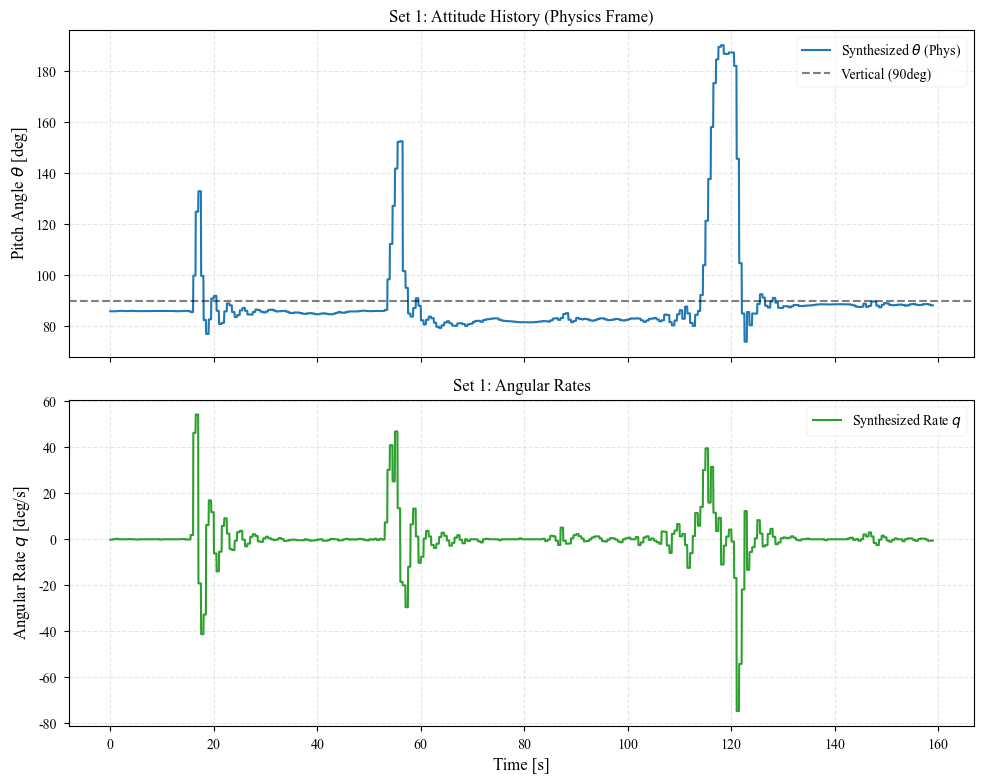

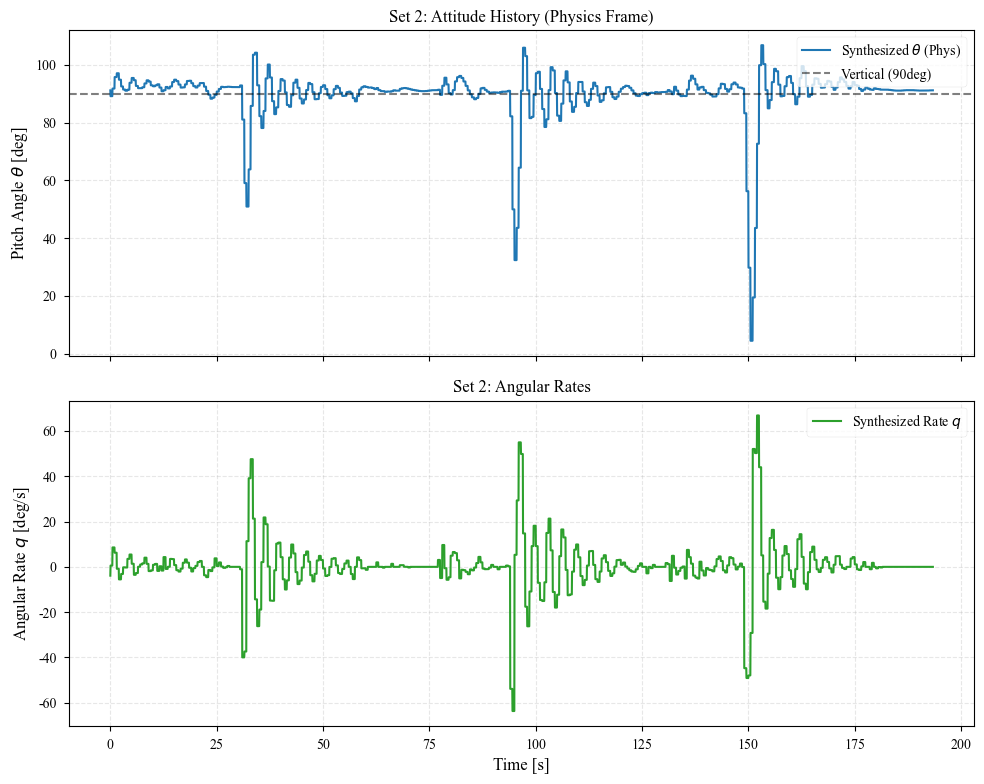

In [3]:
# Scientific Plotting Style Configuration
# Using a style close to SciencePlots / Nature
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-paper')
params = {
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (10, 6),
    'lines.linewidth': 1.5,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
}
mpl.rcParams.update(params)

# Load Data Function
def load_and_process_file(filepath):
    """
    Load data from txt file with columns: angleX, angleY, gyroX, gyroY, time
    Time is in ticks (1ms per tick)
    
    Synthesizes a combined Theta and Gyro (q) using PCA to handle 2D decay coupling.
    converts Laboratory Coordinates (0 deg vertical) to Physics Coordinates (90 deg vertical).
    """
    try:
        # Read whitespace separated file, handling potential non-numeric values
        df = pd.read_csv(filepath, delim_whitespace=True, on_bad_lines='skip')
        
        # Ensure numeric types (force conversion, non-numeric becomes NaN)
        numeric_cols = ['angleX', 'angleY', 'gyroX', 'gyroY', 'time']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Drop rows with NaN if any parsing failed
        df.dropna(inplace=True)

        if df.empty:
            print(f"Warning: File {filepath} resulted in empty dataframe after cleaning.")
            return None, None
        
        # Calculate Time (s) from ticks
        t_ticks = df['time'].values
        t_seconds = (t_ticks - t_ticks[0]) / 1000.0
        df['Time_s'] = t_seconds
        
        # --- 1. Synthesize 2D Motion into 1D (Principal Oscillation Axis) ---
        # The body oscillates in a plane that might not align with X or Y.
        # We use PCA to find the principal axis of the Angle trajectory.
        angle_data = df[['angleX', 'angleY']].values
        pca = PCA(n_components=1)
        # Project angles onto the principal component
        angle_proj = pca.fit_transform(angle_data).flatten()
        
        # Determine sign convention: Make the largest initial excursion positive (arbitrary but consistent)
        # or simply align so that the "positive" direction corresponds to the major variation
        # Here we just use the PCA output.
        
        # Project angular rates (gyro) onto the SAME principal axis component
        # The principal component vector is pca.components_[0]
        principal_axis = pca.components_[0]
        
        # Gyro projection: dot product of gyro vector [gx, gy] with principal axis [ux, uy]
        gyro_data = df[['gyroX', 'gyroY']].values
        gyro_proj = np.dot(gyro_data, principal_axis)
        
        # Store Raw Combined Data (Laboratory Frame, centered at ~0)
        df['Angle_Comb_Lab_deg'] = angle_proj
        df['Gyro_Comb_Lab_deg'] = gyro_proj
        
        # --- 2. Coordinate Transformation (Lab -> Physics) ---
        # User Req: Lab 0 deg (Vertical) -> Physics 90 deg (Vertical)
        # Formula: Theta_Phys = 90 + Theta_Lab
        # Note: We must ensure units are consistent.
        
        deg2rad = np.pi / 180.0
        
        # Physics Angles (in Degrees for plotting)
        df['Theta_Phys_deg'] = 90.0 + df['Angle_Comb_Lab_deg']
        
        # Physics Rates (deg/s) - Rates are unchanged by static offset
        df['q_Phys_deg'] = df['Gyro_Comb_Lab_deg']
        
        # Radians for Calculation
        df['Theta_Phys_rad'] = np.radians(df['Theta_Phys_deg'])
        df['q_Phys_rad'] = np.radians(df['q_Phys_deg'])
        
        # Also keep raw components in Radians if needed
        cols_to_convert = ['angleX', 'angleY', 'gyroX', 'gyroY']
        for col in cols_to_convert:
            df[f'{col}_rad'] = df[col].astype(float) * deg2rad
            
        return df, t_seconds
        
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None, None
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None

# Load both datasets
file1_path = '../dq_analysis_1.txt' # Adjust path relative to notebook location
file2_path = '../dq_analysis_2.txt'

# Try absolute path if relative fails
if not os.path.exists(file1_path):
    file1_path = 'd:/AD_v2_CFD_stage_1/dq_analysis_1.txt'
    file2_path = 'd:/AD_v2_CFD_stage_1/dq_analysis_2.txt'

df1, t1 = load_and_process_file(file1_path)
df2, t2 = load_and_process_file(file2_path)

if df1 is not None and df2 is not None:
    print(f"Dataset 1 loaded: {len(df1)} samples")
    print(f"Dataset 2 loaded: {len(df2)} samples")

    # Plotting: Two Separate Figures for Clarity
    # Figure 1: Dataset 1
    # We plot the Synthesized Physics Angle (oscillating around 90)
    fig1, (ax1_1, ax1_2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Set 1 Angles
    ax1_1.plot(df1['Time_s'], df1['Theta_Phys_deg'], color='#1f77b4', label=r'Synthesized $\theta$ (Phys)')
    ax1_1.axhline(90, color='k', linestyle='--', alpha=0.5, label='Vertical (90deg)')
    ax1_1.set_ylabel(r'Pitch Angle $\theta$ [deg]')
    ax1_1.set_title('Set 1: Attitude History (Physics Frame)')
    ax1_1.legend(loc='upper right')
    ax1_1.grid(True)

    # Set 1 Angular Rates
    ax1_2.plot(df1['Time_s'], df1['q_Phys_deg'], color='#2ca02c', label=r'Synthesized Rate $q$')
    ax1_2.set_xlabel('Time [s]')
    ax1_2.set_ylabel(r'Angular Rate $q$ [deg/s]')
    ax1_2.set_title('Set 1: Angular Rates')
    ax1_2.legend()
    ax1_2.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Figure 2: Dataset 2
    fig2, (ax2_1, ax2_2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Set 2 Angles
    ax2_1.plot(df2['Time_s'], df2['Theta_Phys_deg'], color='#1f77b4', label=r'Synthesized $\theta$ (Phys)')
    ax2_1.axhline(90, color='k', linestyle='--', alpha=0.5, label='Vertical (90deg)')
    ax2_1.set_ylabel(r'Pitch Angle $\theta$ [deg]')
    ax2_1.set_title('Set 2: Attitude History (Physics Frame)')
    ax2_1.legend(loc='upper right')
    ax2_1.grid(True)

    # Set 2 Angular Rates
    ax2_2.plot(df2['Time_s'], df2['q_Phys_deg'], color='#2ca02c', label=r'Synthesized Rate $q$')
    ax2_2.set_xlabel('Time [s]')
    ax2_2.set_ylabel(r'Angular Rate $q$ [deg/s]')
    ax2_2.set_title('Set 2: Angular Rates')
    ax2_2.legend()
    ax2_2.grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("Could not load one or both datasets.")

#### 1.1 选取set2作为参数辨识数据集

Data Smoothed: Resampled to 193422 points
Detected Maxima at: [  1.929  34.434  97.098 153.138]
Detected Minima at: [ 32.438  95.101 150.598]


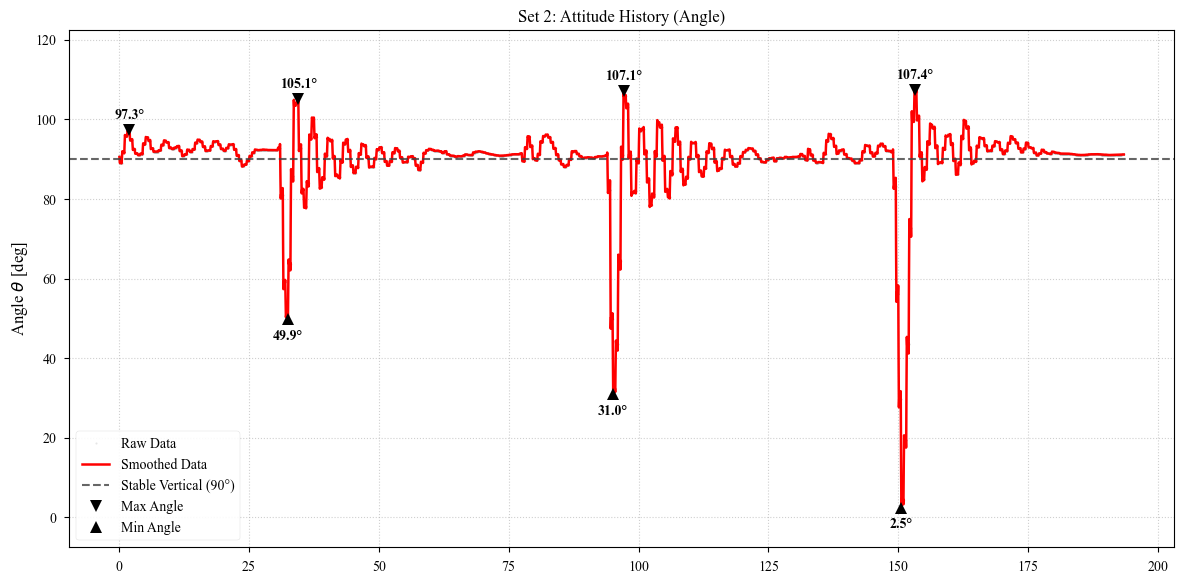

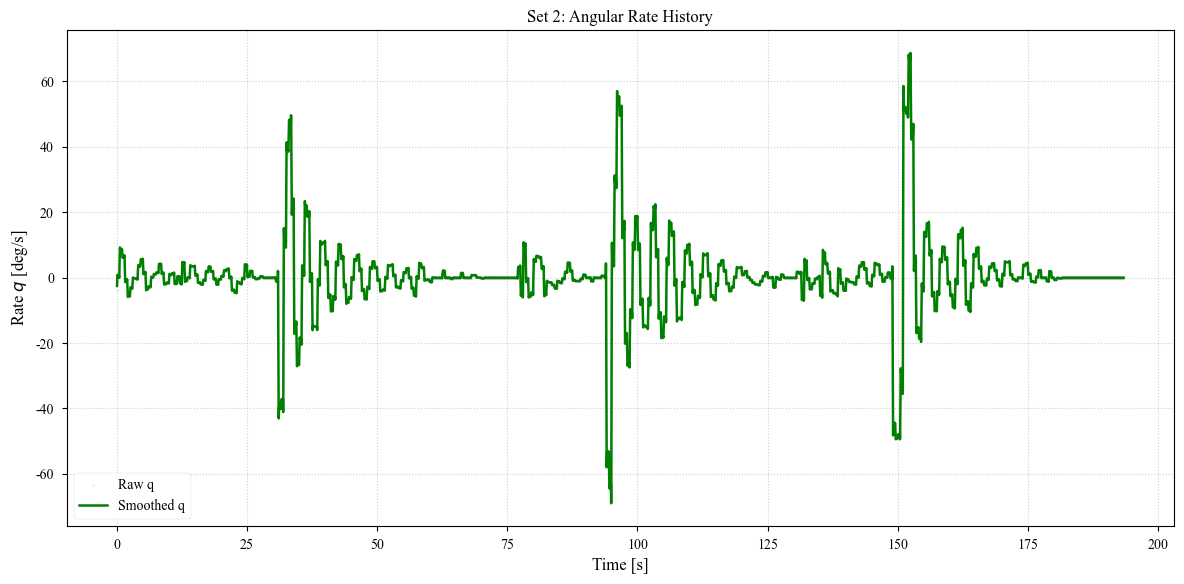

In [4]:
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d

# --- 2.1 Interpolation & Smoothing (For Set 2) ---

# Copy raw data
data_raw = df2.copy()

# A. Interpolation (Quadratic)
t_raw = data_raw['Time_s'].values
dt_uniform = 0.001 
t_uniform = np.arange(t_raw[0], t_raw[-1], dt_uniform)

f_theta = interp1d(t_raw, data_raw['Theta_Phys_deg'], kind='quadratic', fill_value="extrapolate")
f_q = interp1d(t_raw, data_raw['q_Phys_deg'], kind='quadratic', fill_value="extrapolate")

theta_interp = f_theta(t_uniform)
q_interp = f_q(t_uniform)

# B. Smoothing (Savgol)
window_len = 201 
poly_order = 2 

theta_smooth = savgol_filter(theta_interp, window_len, poly_order)
q_smooth = savgol_filter(q_interp, window_len, poly_order)

# Create Cleaned DataFrame
df2_clean = pd.DataFrame({
    'Time_s': t_uniform,
    'Theta_Phys_deg': theta_smooth,
    'q_Phys_deg': q_smooth
})
df2_clean['Theta_Phys_rad'] = np.radians(df2_clean['Theta_Phys_deg'])
df2_clean['q_Phys_rad'] = np.radians(df2_clean['q_Phys_deg'])

# Update Global
df2 = df2_clean
t2 = df2['Time_s'].values

print(f"Data Smoothed: Resampled to {len(df2)} points")

# --- Peak Detection ---
# 1. Maxima (Peaks > 95)
peaks_max, _ = find_peaks(theta_smooth, height=95, distance=20000)

# 2. Minima (Valleys < 85) - Using inverted signal
# "Smallest angle peak" interpreted as the local minima (valleys)
peaks_min, _ = find_peaks(-theta_smooth, height=-85, distance=20000)

print(f"Detected Maxima at: {t_uniform[peaks_max]}")
print(f"Detected Minima at: {t_uniform[peaks_min]}")

# --- Visualization 1: Angle History ---
plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# Plot Data
ax1.plot(t_raw, data_raw['Theta_Phys_deg'], 'k.', markersize=3, alpha=0.1, label='Raw Data')
ax1.plot(t_uniform, theta_smooth, 'r-', linewidth=1.8, label='Smoothed Data')
ax1.axhline(90, color='#404040', linestyle='--', linewidth=1.5, alpha=0.8, label='Stable Vertical (90°)')

# Annotate Maxima (Top)
ax1.plot(t_uniform[peaks_max], theta_smooth[peaks_max], 'kv', markersize=8, label='Max Angle', zorder=5)
for p in peaks_max:
    val = theta_smooth[p]
    ax1.annotate(f"{val:.1f}°", xy=(t_uniform[p], val), xytext=(0, 8), 
                 textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

# Annotate Minima (Bottom)
ax1.plot(t_uniform[peaks_min], theta_smooth[peaks_min], 'k^', markersize=8, label='Min Angle', zorder=5)
for p in peaks_min:
    val = theta_smooth[p]
    ax1.annotate(f"{val:.1f}°", xy=(t_uniform[p], val), xytext=(0, -15), 
                 textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

# Adjust Limit to prevent clipping text
y_min, y_max = theta_smooth.min(), theta_smooth.max()
ax1.set_ylim(y_min - 10, y_max + 15)  # Add Margin

ax1.set_ylabel(r'Angle $\theta$ [deg]')
ax1.set_title('Set 2: Attitude History (Angle)')
ax1.legend(loc='lower left', frameon=True, framealpha=0.9) # Legend at lower left
ax1.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Visualization 2: Angular Rate ---
plt.figure(figsize=(12, 6))
ax2 = plt.gca()

ax2.plot(t_raw, data_raw['q_Phys_deg'], 'k.', markersize=3, alpha=0.1, label='Raw q')
ax2.plot(t_uniform, q_smooth, 'g-', linewidth=1.8, label='Smoothed q')

ax2.set_ylabel(r'Rate $q$ [deg/s]')
ax2.set_xlabel('Time [s]')
ax2.set_title('Set 2: Angular Rate History')
ax2.legend(loc='lower left', frameon=True, framealpha=0.9) # Legend at lower left
ax2.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

--- Spectral Analysis ---
Dominant Oscillation Frequency: 0.284 Hz
Filter Cutoff Frequency: 1.706 Hz (Factor: 6.0x)


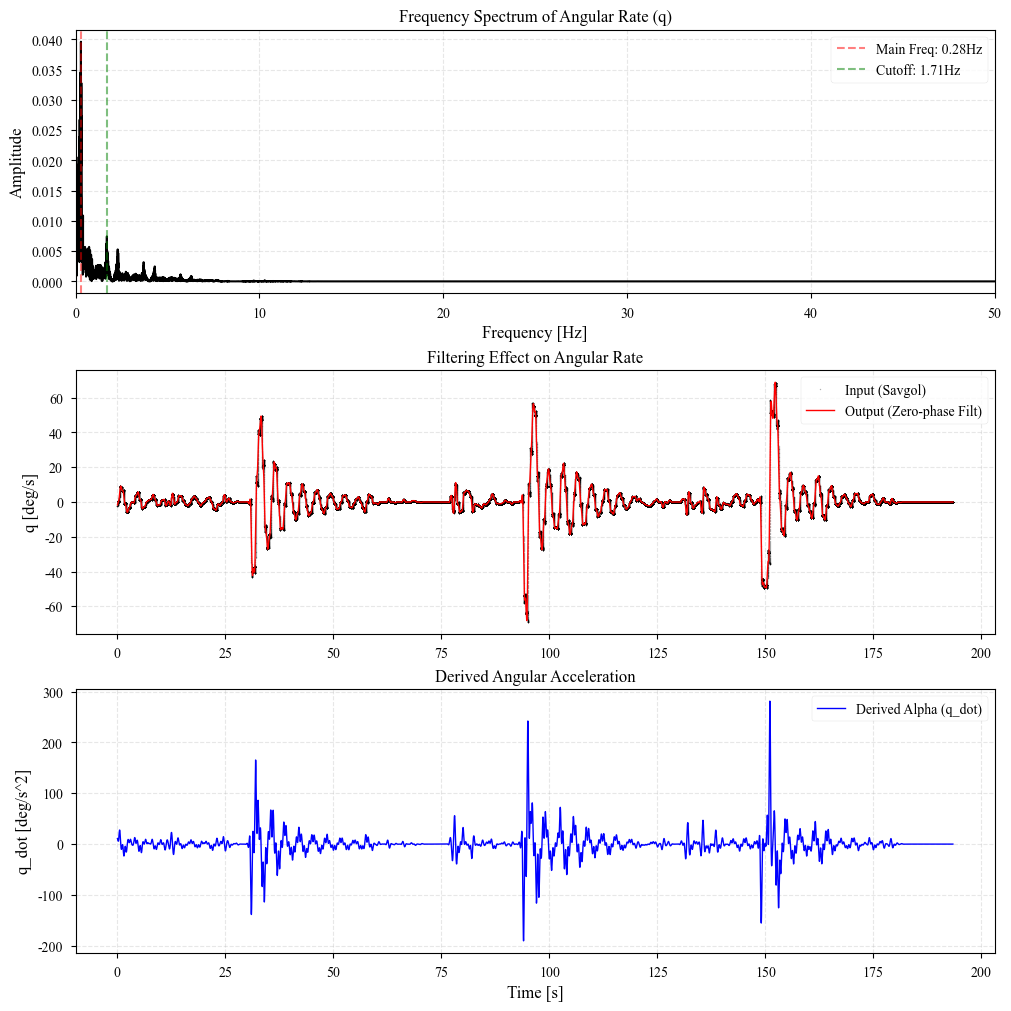

In [5]:
from scipy.signal import butter, filtfilt, welch

# --- Step 1: Advanced Signal Processing for Identification ---

# 1. Data Preparation
# Recalculate time step from the uniform grid in df2
t_proc = df2['Time_s'].values
dt_proc = t_proc[1] - t_proc[0]
q_proc = df2['q_Phys_rad'].values
theta_proc = df2['Theta_Phys_rad'].values

# 2. Spectral Analysis (FFT) to determine Cutoff Frequency
n_samples = len(q_proc)
freqs = np.fft.rfftfreq(n_samples, d=dt_proc)
fft_mag = np.abs(np.fft.rfft(q_proc)) / n_samples

# Find Dominant Frequency (skip DC component at index 0)
dom_idx = np.argmax(fft_mag[1:]) + 1
f_dom = freqs[dom_idx]

print(f"--- Spectral Analysis ---")
print(f"Dominant Oscillation Frequency: {f_dom:.3f} Hz")

# 3. Filter Design (Butterworth Lowpass)
# Strategy: Cutoff at 6x dominant frequency to keep dynamics but kill noise
f_cutoff_ratio = 6.0 
f_cutoff = f_cutoff_ratio * f_dom
nyquist = 0.5 / dt_proc
b, a = butter(N=4, Wn=f_cutoff / nyquist, btype='low')

print(f"Filter Cutoff Frequency: {f_cutoff:.3f} Hz (Factor: {f_cutoff_ratio}x)")

# 4. Zero-phase Filtering (filtfilt) & Differentiation
# Apply filter to both Theta and q for consistency
q_filt = filtfilt(b, a, q_proc)
theta_filt = filtfilt(b, a, theta_proc)

# Compute Angular Acceleration (q_dot) using gradient
q_dot_filt = np.gradient(q_filt, dt_proc)

# Store in DataFrame for next steps
df2['q_filt_rad'] = q_filt
df2['Theta_filt_rad'] = theta_filt
df2['q_dot_filt_rad'] = q_dot_filt
df2['q_dot_filt_deg'] = np.degrees(q_dot_filt) # For checking

# --- Visualization of Step 1 Results ---
fig, axes = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)

# Plot 1: Spectrum
axes[0].plot(freqs, fft_mag, 'k-', lw=1.5)
axes[0].axvline(f_dom, color='r', linestyle='--', alpha=0.5, label=f'Main Freq: {f_dom:.2f}Hz')
axes[0].axvline(f_cutoff, color='g', linestyle='--', alpha=0.5, label=f'Cutoff: {f_cutoff:.2f}Hz')
axes[0].set_xlim(0, 50) # Zoom in on low freq
axes[0].set_title('Frequency Spectrum of Angular Rate (q)')
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Filtering Effect on q
axes[1].plot(t_proc, df2['q_Phys_deg'], 'k.', ms=2, alpha=0.3, label='Input (Savgol)')
axes[1].plot(t_proc, np.degrees(q_filt), 'r-', lw=1, label='Output (Zero-phase Filt)')
axes[1].set_title('Filtering Effect on Angular Rate')
axes[1].set_ylabel('q [deg/s]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Derived Angular Acceleration
axes[2].plot(t_proc, df2['q_dot_filt_deg'], 'b-', lw=1, label='Derived Alpha (q_dot)')
axes[2].set_title('Derived Angular Acceleration')
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('q_dot [deg/s^2]')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.show()

## 2. Select Identification Range
Use the slider to select the time window for identification (e.g., exclude initial transient or noisy tail).

--- Automated Segmentation Report ---
[Segment 1 (Target ~49.9°)] Start Locked: t=32.248s, theta=49.88° | Len: 42753
[Segment 2 (Target ~31.0°)] Start Locked: t=95.296s, theta=30.87° | Len: 34705
[Segment 3 (Target ~2.5°)] Start Locked: t=150.791s, theta=2.05° | Len: 39210

Total Stacked Samples for Identification: 116668


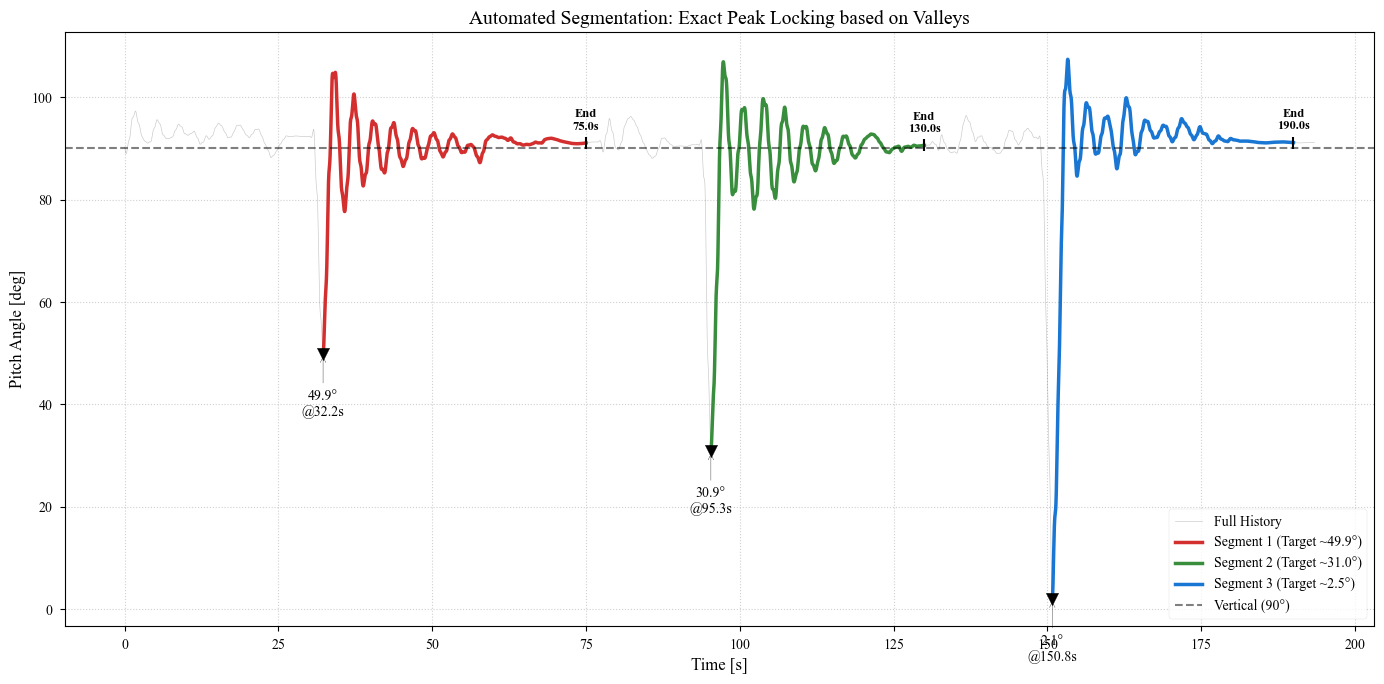

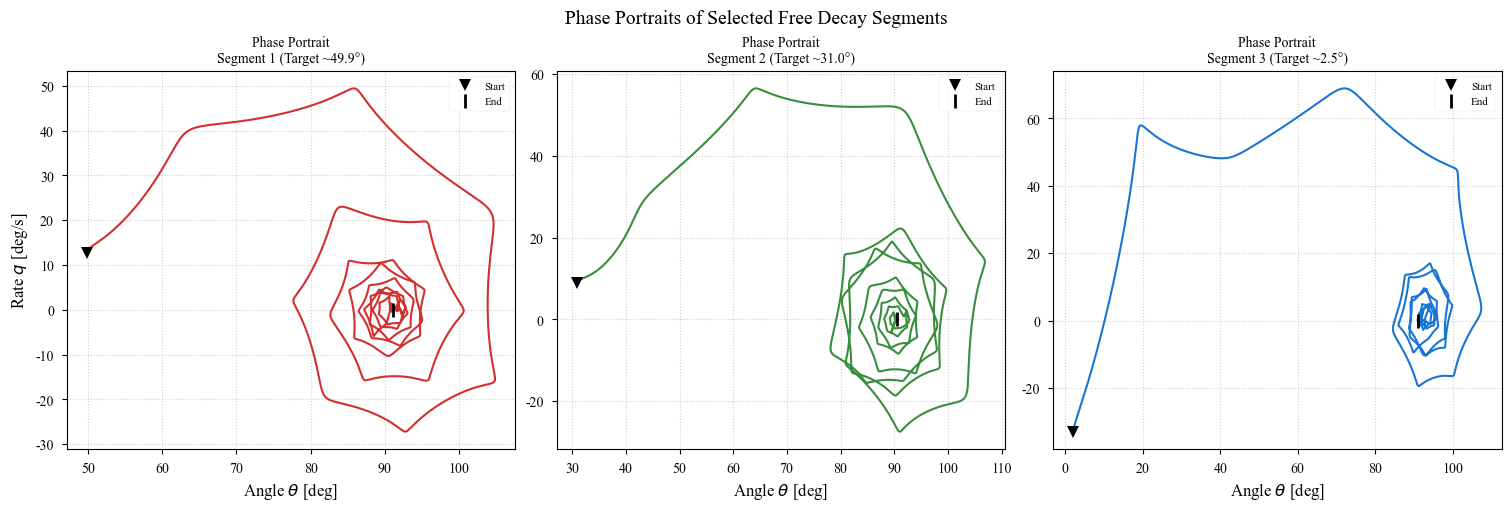

In [6]:
# --- Step 2: Algorithmic Segmentation (Peak Locking) ---

# Define Search Windows for the Start Points based on visual inspection of the "Attitude History" plot
# We look for the local MINIMA (valleys) corresponding to ~49.9, ~31.0, ~2.5 degrees.
# Structure: (Search_Start_Time, Search_End_Time, Exact_Cut_End_Time, Description)
search_configs = [
    (30.0, 36.0, 75.0, "Segment 1 (Target ~49.9°)"),
    (94.0, 100.0, 130.0, "Segment 2 (Target ~31.0°)"),
    (145.0, 155.0, 190.0, "Segment 3 (Target ~2.5°)")
]

Theta_stack = []
q_stack = []
q_dot_stack = []

# Prepare Visualization
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Plot the full background signal for context
ax.plot(df2['Time_s'], np.degrees(df2['Theta_filt_rad']), 'k-', linewidth=0.5, alpha=0.2, label='Full History')

print("--- Automated Segmentation Report ---")

color_cycle = ['#D32F2F', '#388E3C', '#1976D2'] # Red, Green, Blue

for i, (search_t0, search_t1, cut_t_end, desc) in enumerate(search_configs):
    # 1. Isolate the search region to find the specific peak/valley
    region_mask = (df2['Time_s'] >= search_t0) & (df2['Time_s'] <= search_t1)
    df_region = df2.loc[region_mask]
    
    if df_region.empty:
        print(f"Warning: Search region empty for {desc}")
        continue
        
    # 2. Find the exact MINIMUM index in this region (valleys below 90)
    # Using filtered data for precision
    min_idx = df_region['Theta_filt_rad'].idxmin()
    
    # Retrieve exact start parameters
    t_start_exact = df2.loc[min_idx, 'Time_s']
    val_start_rad = df2.loc[min_idx, 'Theta_filt_rad']
    val_start_deg = np.degrees(val_start_rad)
    
    # 3. Slice the Segment (Start at Exact Peak -> Fixed End Time)
    # Note: We cut from the exact peak to capture the full decay
    seg_mask = (df2['Time_s'] >= t_start_exact) & (df2['Time_s'] <= cut_t_end)
    
    th_seg = df2.loc[seg_mask, 'Theta_filt_rad'].values
    q_seg = df2.loc[seg_mask, 'q_filt_rad'].values
    qd_seg = df2.loc[seg_mask, 'q_dot_filt_rad'].values
    t_seg = df2.loc[seg_mask, 'Time_s'].values
    
    # Append to stack
    Theta_stack.append(th_seg)
    q_stack.append(q_seg)
    q_dot_stack.append(qd_seg)
    
    # 4. Visualization of the Segment
    color = color_cycle[i % len(color_cycle)]
    ax.plot(t_seg, np.degrees(th_seg), color=color, linewidth=2.5, label=f'{desc}')
    
    # Mark Start Point
    ax.scatter([t_start_exact], [val_start_deg], color='k', s=80, marker='v', zorder=10)
    ax.annotate(f"{val_start_deg:.1f}°\n@{t_start_exact:.1f}s", 
                xy=(t_start_exact, val_start_deg), 
                xytext=(0, -25), textcoords="offset points", 
                ha='center', va='top', fontsize=10, 
                arrowprops=dict(arrowstyle="->", color='k'))

    # Mark End Point
    if len(t_seg) > 0:
        t_end_actual = t_seg[-1]
        val_end_deg = np.degrees(th_seg[-1])
        ax.scatter([t_end_actual], [val_end_deg], color='k', s=80, marker='|', zorder=10)
        ax.text(t_end_actual, val_end_deg + 2, f"End\n{cut_t_end}s", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    print(f"[{desc}] Start Locked: t={t_start_exact:.3f}s, theta={val_start_deg:.2f}° | Len: {len(th_seg)}")

# Concatenate all stacks into single arrays for Regression
if len(Theta_stack) > 0:
    Theta_all = np.concatenate(Theta_stack)
    q_all = np.concatenate(q_stack)
    q_dot_all = np.concatenate(q_dot_stack)
    print(f"\nTotal Stacked Samples for Identification: {len(Theta_all)}")
else:
    print("\nError: No valid segments found.")
    Theta_all = np.array([])
    q_all = np.array([])
    q_dot_all = np.array([])

# Finalize Plot
ax.axhline(90, color='k', linestyle='--', alpha=0.5, label='Vertical (90°)')
ax.set_title('Automated Segmentation: Exact Peak Locking based on Valleys', fontsize=14)
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_ylabel('Pitch Angle [deg]', fontsize=12)
ax.legend(loc='lower right', frameon=True)
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Visualization: Phase Portraits (1 row, 3 columns) ---
if len(Theta_stack) > 0:
    fig_phase, axes_phase = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    
    for i, ax_p in enumerate(axes_phase):
        if i < len(Theta_stack):
            th_deg = np.degrees(Theta_stack[i])
            q_deg = np.degrees(q_stack[i])
            desc = search_configs[i][3] # Get description
            
            # Plot trajectory
            # Use same colors as time plot
            color = color_cycle[i % len(color_cycle)]
            ax_p.plot(th_deg, q_deg, color=color, linewidth=1.5)
            
            # Mark Start (Triangle Down)
            ax_p.plot(th_deg[0], q_deg[0], 'kv', markersize=8, label='Start')
            
            # Mark End (Vertical Bar)
            ax_p.plot(th_deg[-1], q_deg[-1], 'k|', markersize=10, markeredgewidth=2, label='End')
            
            # Formatting
            ax_p.set_title(f'Phase Portrait\n{desc}', fontsize=10)
            ax_p.set_xlabel(r'Angle $\theta$ [deg]')
            if i == 0:
                ax_p.set_ylabel(r'Rate $q$ [deg/s]')
            ax_p.grid(True, linestyle=':', alpha=0.6)
            ax_p.legend(loc='best', fontsize=8)
        else:
            ax_p.axis('off')
            
    fig_phase.suptitle('Phase Portraits of Selected Free Decay Segments', fontsize=14)
    plt.show()

## 3. Decoupled Identification: Step 1 - Kinematics & Frequency

### 3.1 辨识新思路：分步解耦 (Stepwise Decoupling)
为了避免逆动力学回归中的“惯量-刚度”共线性陷阱，我们将辨识过程拆解为物理上独立的步骤：

1.  **Step 1: 频率锁定 (Frequency Locking)**
    *   通过统计波峰/波谷的时间差，精确计算系统的实际振荡频率 $\omega_d$。
    *   这是系统最可靠的“指纹”，不依赖于任何力学模型假设。

2.  **Step 2: 刚度/惯量约束 (Stiffness/Inertia Constraints)** (后续步骤)
    *   利用 $K = I \omega^2$ 关系，检查“几何刚度” $K_{geo}$ 与“理论惯量”是否匹配。
    *   确定是修正在 $K$ (线缆影响) 还是在 $I$ ($\mu$ 渗透率)。

3.  **Step 3: 能量衰减 (Energy Decay)** (后续步骤)
    *   利用振幅衰减率辨识阻尼系数，彻底规避微分噪声。

 STEP 1: ROBUST FREQUENCY LOCKING (Peaks + Zero-Cross + ACF + PSD)
Peak params: MIN_DIST=0.40s (400 samples), HEIGHT>0.5deg, PROM>0.3deg
Period gate: [1.0, 8.0] s | MAD(z<=3.5)
----------------------------------------------------------------------
Seg 1 [OK]: peaks(max/min)=12/8 | T_peak_med=3.0320s(n=11) | T_zc_med=3.1791s(n=14) | T_ac=3.1300s | T_psd=3.1969s | omega_peak=2.072, omega_zc=1.976, omega_ac=2.007, omega_psd=1.965 rad/s
Seg 2 [OK]: peaks(max/min)=8/9 | T_peak_med=3.4765s(n=8) | T_zc_med=3.3187s(n=13) | T_ac=3.2760s | T_psd=3.2768s | omega_peak=1.807, omega_zc=1.893, omega_ac=1.918, omega_psd=1.917 rad/s
Seg 3 [OK]: peaks(max/min)=10/4 | T_peak_med=3.0140s(n=9) | T_zc_med=3.0888s(n=7) | T_ac=nans | T_psd=3.1208s | omega_peak=2.085, omega_zc=2.034, omega_ac=nan, omega_psd=2.013 rad/s
----------------------------------------------------------------------
GLOBAL (robust, source=ZC) from 34 periods:
  T_median = 3.1984 s | IQR = 0.2161 s
  f_d      = 0.3127 Hz
  omega_d  = 1.96

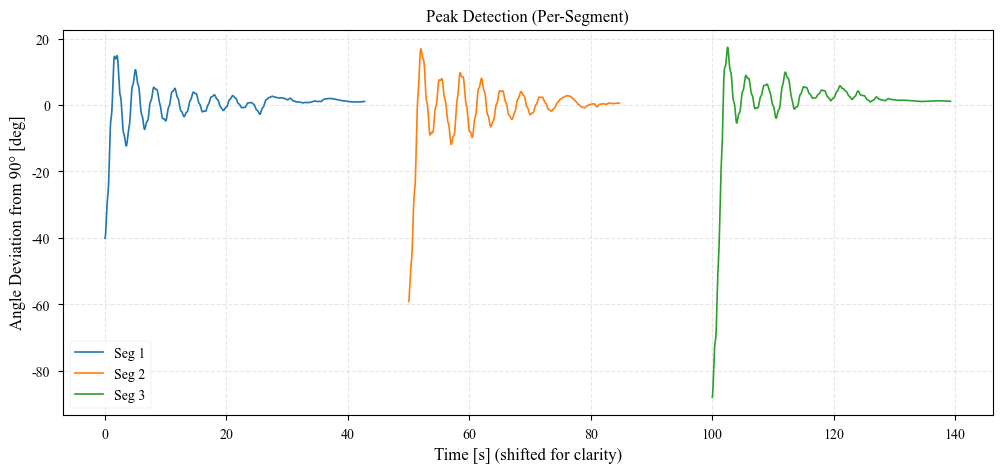

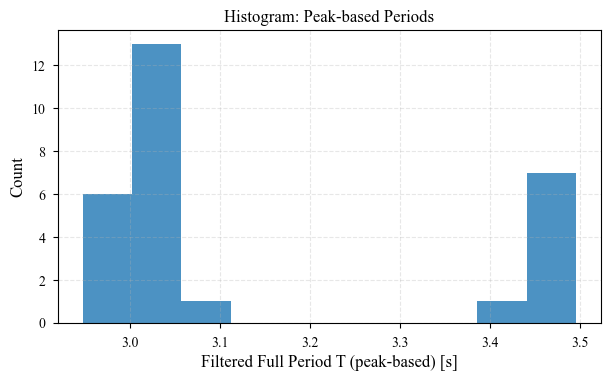

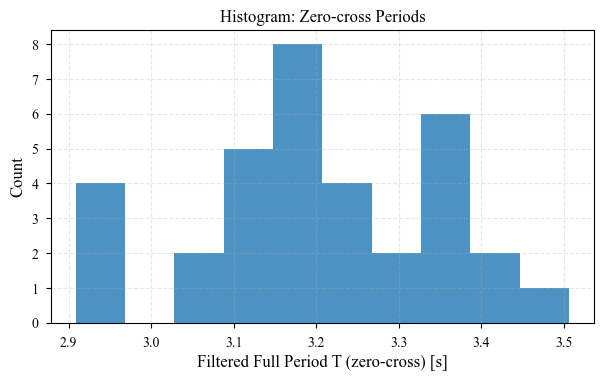

In [7]:
# --- Step 1: Kinematic Frequency Analysis (ROBUST, PER-SEGMENT) ---

print("="*70)
print(" STEP 1: ROBUST FREQUENCY LOCKING (Peaks + Zero-Cross + ACF + PSD)")
print("="*70)

# Goal: get a physically trustworthy damped frequency omega_d from free decay.
# Failure modes to avoid: missed peaks -> measured period doubles (2T); false split -> T/2.
# Strategy (per segment):
#   A) Full-period from same-type extrema (max-to-max, min-to-min) + MAD outlier rejection
#   B) Full-period from zero-crossings (t[k+2]-t[k]) + MAD outlier rejection
#   C) Autocorrelation (ACF): pick the FIRST credible ACF peak (avoid 2T)
#   D) PSD peak (Welch) as an independent frequency estimator (with sufficient frequency resolution)
# Then: report per-segment medians + consistency flags; global omega uses the most reliable estimator available.

from scipy.signal import welch

dt_uniform = 0.001  # 1000 Hz grid from interpolation step

# Physical prior (broad, but excludes nonsense)
T_MIN, T_MAX = 1.0, 8.0   # seconds; adjust only if you have strong evidence
F_MIN, F_MAX = 1.0/T_MAX, 1.0/T_MIN
MIN_DIST_S = 0.40          # peak refractory time [s] to avoid double-counting noise
HEIGHT_DEG = 0.5           # minimum excursion [deg] from 90deg to count as peak
PROM_DEG = 0.3             # prominence threshold [deg]
min_dist_samples = int(MIN_DIST_S / dt_uniform)

def _robust_filter_periods(periods_s, t_min=T_MIN, t_max=T_MAX):
    periods_s = np.asarray(periods_s, dtype=float)
    if periods_s.size == 0:
        return periods_s
    # 1) Physical gate
    periods_s = periods_s[(periods_s >= t_min) & (periods_s <= t_max)]
    if periods_s.size < 3:
        return periods_s
    # 2) MAD outlier rejection
    med = np.median(periods_s)
    mad = np.median(np.abs(periods_s - med))
    if mad == 0:
        return periods_s
    z = 0.6745 * (periods_s - med) / mad  # robust z-score
    return periods_s[np.abs(z) <= 3.5]

def _zero_crossing_times(x, dt):
    """Return interpolated zero-crossing times (s) for signal x sampled at dt."""
    x = np.asarray(x, dtype=float)
    if x.size < 2:
        return np.array([])
    s = np.sign(x)
    # treat exact zeros as tiny positives to avoid spurious 'no sign change'
    s[s == 0] = 1.0
    idx = np.where(s[:-1] * s[1:] < 0)[0]  # sign change between i and i+1
    if idx.size == 0:
        return np.array([])
    x0 = x[idx]
    x1 = x[idx + 1]
    denom = (x1 - x0)
    denom[denom == 0] = np.nan
    alpha = -x0 / denom
    t = (idx + alpha) * dt
    t = t[np.isfinite(t)]
    return t

def _zc_full_periods(x, dt):
    """Full periods from zero crossings: T ≈ t[k+2] - t[k]."""
    tzc = _zero_crossing_times(x, dt)
    if tzc.size < 3:
        return np.array([])
    return tzc[2:] - tzc[:-2]

def _autocorr_period_first_peak(x, dt, t_min=T_MIN, t_max=T_MAX):
    """Estimate period by the first credible peak of ACF within [t_min, t_max]."""
    x = np.asarray(x, dtype=float)
    if x.size < 10:
        return np.nan
    x = x - np.mean(x)
    denom = np.dot(x, x)
    if denom <= 0:
        return np.nan
    ac = np.correlate(x, x, mode='full')[x.size-1:] / denom
    lag_min = int(t_min / dt)
    lag_max = min(int(t_max / dt), ac.size - 1)
    if lag_max <= lag_min + 5:
        return np.nan
    ac_win = ac[lag_min:lag_max+1]
    # Find peaks; choose the earliest one above a modest threshold
    pks, props = find_peaks(ac_win, prominence=0.05, height=0.10, distance=max(1, int(0.2 / dt)))
    if pks.size == 0:
        return np.nan
    best = int(pks.min())  # earliest peak reduces risk of picking 2T
    lag = lag_min + best
    return lag * dt

def _psd_period(x, dt, f_min=F_MIN, f_max=F_MAX):
    """Estimate period from PSD peak in [f_min, f_max] using Welch with higher frequency resolution."""
    x = np.asarray(x, dtype=float)
    if x.size < 512:
        return np.nan
    fs = 1.0 / dt
    # Use long segments to improve resolution; add nfft zero-padding for finer bins.
    nperseg = min(16384, x.size)
    if nperseg < 512:
        return np.nan
    nfft = int(8 * 2 ** np.ceil(np.log2(nperseg)))  # zero-pad to refine frequency grid
    f, Pxx = welch(x - np.mean(x), fs=fs, nperseg=nperseg, noverlap=nperseg//2, nfft=nfft, detrend='constant')
    mask = (f >= f_min) & (f <= f_max)
    if not np.any(mask):
        return np.nan
    f_sel = f[mask]
    P_sel = Pxx[mask]
    idx = int(np.argmax(P_sel))
    f0 = float(f_sel[idx])
    if f0 <= 0:
        return np.nan
    return 1.0 / f0

# Containers
segment_results = []
all_T_peak = []
all_T_zc = []

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
shift_s = 0.0
shift_step = 50.0  # seconds, for visual separation only

for seg_idx, th_seg_rad in enumerate(Theta_stack):
    th_deg = np.degrees(th_seg_rad)
    centered = th_deg - 90.0

    # A) Peak-based periods (full cycles)
    pks_max, _ = find_peaks(centered, distance=min_dist_samples, height=HEIGHT_DEG, prominence=PROM_DEG)
    pks_min, _ = find_peaks(-centered, distance=min_dist_samples, height=HEIGHT_DEG, prominence=PROM_DEG)
    T_max = np.diff(pks_max) * dt_uniform if len(pks_max) >= 2 else np.array([])
    T_min = np.diff(pks_min) * dt_uniform if len(pks_min) >= 2 else np.array([])
    T_peak_raw = np.concatenate([T_max, T_min]) if (T_max.size + T_min.size) else np.array([])
    T_peak = _robust_filter_periods(T_peak_raw)

    # B) Zero-crossing based periods (full cycles)
    T_zc_raw = _zc_full_periods(centered, dt_uniform)
    T_zc = _robust_filter_periods(T_zc_raw)

    # C) Autocorrelation (first peak)
    T_ac = _autocorr_period_first_peak(centered, dt_uniform)

    # D) PSD peak
    T_psd = _psd_period(centered, dt_uniform)

    # Robust summary
    T_peak_med = float(np.median(T_peak)) if T_peak.size else np.nan
    T_zc_med = float(np.median(T_zc)) if T_zc.size else np.nan
    omega_peak = 2 * np.pi / T_peak_med if np.isfinite(T_peak_med) and T_peak_med > 0 else np.nan
    omega_zc = 2 * np.pi / T_zc_med if np.isfinite(T_zc_med) and T_zc_med > 0 else np.nan
    omega_ac = 2 * np.pi / T_ac if np.isfinite(T_ac) and T_ac > 0 else np.nan
    omega_psd = 2 * np.pi / T_psd if np.isfinite(T_psd) and T_psd > 0 else np.nan

    # Consistency flag: primary check is ZC vs PEAK; PSD/ACF are cross-checks
    flag = "OK"
    if np.isfinite(T_zc_med) and np.isfinite(T_peak_med):
        rel = abs(T_zc_med - T_peak_med) / ((T_zc_med + T_peak_med) / 2.0)
        if rel > 0.10:
            flag = "CHECK"
    elif np.isfinite(T_zc_med) or np.isfinite(T_peak_med):
        flag = "CHECK"
    else:
        flag = "FAIL"

    segment_results.append({
        "seg": seg_idx + 1,
        "n_max": int(len(pks_max)),
        "n_min": int(len(pks_min)),
        "T_peak_n": int(T_peak.size),
        "T_zc_n": int(T_zc.size),
        "T_peak_med": T_peak_med,
        "T_zc_med": T_zc_med,
        "T_ac": float(T_ac) if np.isfinite(T_ac) else np.nan,
        "T_psd": float(T_psd) if np.isfinite(T_psd) else np.nan,
        "omega_peak": omega_peak,
        "omega_zc": omega_zc,
        "omega_ac": omega_ac,
        "omega_psd": omega_psd,
        "flag": flag,
    })

    if T_peak.size:
        all_T_peak.append(T_peak)
    if T_zc.size:
        all_T_zc.append(T_zc)

    # Plot signal + detected peaks
    t_axis = np.arange(centered.size) * dt_uniform + shift_s
    ax.plot(t_axis, centered, lw=1.2, label=f"Seg {seg_idx+1}")
    if len(pks_max):
        ax.plot(t_axis[pks_max], centered[pks_max], 'rx', ms=5)
    if len(pks_min):
        ax.plot(t_axis[pks_min], centered[pks_min], 'bx', ms=5)
    shift_s += shift_step

# Print report
print(f"Peak params: MIN_DIST={MIN_DIST_S:.2f}s ({min_dist_samples} samples), HEIGHT>{HEIGHT_DEG}deg, PROM>{PROM_DEG}deg")
print(f"Period gate: [{T_MIN:.1f}, {T_MAX:.1f}] s | MAD(z<=3.5)")
print("-" * 70)
for r in segment_results:
    print(
        f"Seg {r['seg']} [{r['flag']}]: peaks(max/min)={r['n_max']}/{r['n_min']} | "
        f"T_peak_med={r['T_peak_med']:.4f}s(n={r['T_peak_n']}) | "
        f"T_zc_med={r['T_zc_med']:.4f}s(n={r['T_zc_n']}) | "
        f"T_ac={r['T_ac']:.4f}s | T_psd={r['T_psd']:.4f}s | "
        f"omega_peak={r['omega_peak']:.3f}, omega_zc={r['omega_zc']:.3f}, omega_ac={r['omega_ac']:.3f}, omega_psd={r['omega_psd']:.3f} rad/s"
    )
print("-" * 70)

# Global robust omega: prefer ZC aggregate, then PSD (per-seg), then PEAK aggregate
T_all_zc = np.concatenate(all_T_zc) if len(all_T_zc) else np.array([])
T_all_peak = np.concatenate(all_T_peak) if len(all_T_peak) else np.array([])
T_all_psd = np.array([r["T_psd"] for r in segment_results if np.isfinite(r["T_psd"])])

src = None
if T_all_zc.size >= 6:
    T_all = T_all_zc
    src = "ZC"
elif T_all_psd.size >= 2:
    T_all = T_all_psd
    src = "PSD"
else:
    T_all = T_all_peak
    src = "PEAK"

T_all = _robust_filter_periods(T_all)
if T_all.size >= 2:
    T_med = float(np.median(T_all))
    T_iqr = float(np.percentile(T_all, 75) - np.percentile(T_all, 25)) if T_all.size >= 4 else np.nan
    omega_d_final = 2 * np.pi / T_med
    f_d_final = 1.0 / T_med
    print(f"GLOBAL (robust, source={src}) from {T_all.size} periods:")
    print(f"  T_median = {T_med:.4f} s" + (f" | IQR = {T_iqr:.4f} s" if np.isfinite(T_iqr) else ""))
    print(f"  f_d      = {f_d_final:.4f} Hz")
    print(f"  omega_d  = {omega_d_final:.4f} rad/s")
else:
    print("ERROR: Not enough valid period estimates after filtering.")
    omega_d_final = np.nan
    f_d_final = np.nan

# Theoretical comparison (note: omega_d is damped; omega_n >= omega_d)
if np.isfinite(omega_d_final):
    K_geo_val = B_force * x_b
    omega_dry = np.sqrt(K_geo_val / I_yy_dry)
    omega_virtual_mu06 = np.sqrt(K_geo_val / I_virtual)
    print("-" * 70)
    print(f"Theoretical omega_n (dry, mu=0):  {omega_dry:.4f} rad/s")
    print(f"Theoretical omega_n (mu=0.6):     {omega_virtual_mu06:.4f} rad/s")
    print("NOTE: This is omega_d (measured) vs omega_n (undamped approx).")
    omega_exp = omega_d_final
else:
    omega_exp = None

# Plot formatting
ax.set_title('Peak Detection (Per-Segment)')
ax.set_xlabel('Time [s] (shifted for clarity)')
ax.set_ylabel('Angle Deviation from 90° [deg]')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.show()

# Histograms
if T_all_peak.size:
    plt.figure(figsize=(7, 3.8))
    plt.hist(T_all_peak, bins=min(30, max(10, int(np.sqrt(T_all_peak.size)))), alpha=0.8)
    plt.xlabel('Filtered Full Period T (peak-based) [s]')
    plt.ylabel('Count')
    plt.title('Histogram: Peak-based Periods')
    plt.grid(True, alpha=0.3)
    plt.show()
if T_all_zc.size:
    plt.figure(figsize=(7, 3.8))
    plt.hist(T_all_zc, bins=min(30, max(10, int(np.sqrt(T_all_zc.size)))), alpha=0.8)
    plt.xlabel('Filtered Full Period T (zero-cross) [s]')
    plt.ylabel('Count')
    plt.title('Histogram: Zero-cross Periods')
    plt.grid(True, alpha=0.3)
    plt.show()

In [8]:
# --- Step 2: Stiffness & Inertia Decoupling (Constraint Analysis) ---

print("="*60)
print(" STEP 2: STIFFNESS–INERTIA DECOUPLING (μ and K_cable feasibility)")
print("="*60)

# This step uses the locked damped frequency from Step 1 (omega_d_final).
# Assumption for constraint analysis: omega_n ≈ omega_d (light-to-moderate damping).
# If damping is strong, omega_n will be slightly higher than omega_d; interpret ranges accordingly.

try:
    omega_exp = float(omega_d_final)
except NameError:
    raise RuntimeError("omega_d_final not defined. Run Step 1 first.")

# Pull robust period samples from Step 1 if available (preferred for uncertainty)
omega_q25 = omega_exp
omega_q75 = omega_exp
try:
    if 'T_all' in globals():
        T_all_local = np.asarray(T_all, dtype=float)
        T_all_local = T_all_local[np.isfinite(T_all_local) & (T_all_local > 0)]
        if T_all_local.size >= 8:
            omega_samples = 2 * np.pi / T_all_local
            omega_q25 = float(np.percentile(omega_samples, 25))
            omega_q75 = float(np.percentile(omega_samples, 75))
except Exception:
    pass

omega_lo = min(omega_q25, omega_q75)
omega_hi = max(omega_q25, omega_q75)

# Known restoring slope from geometry (about equilibrium)
K_geo_val = float(B_force * x_b)  # Nm/rad
I_base = float(I_yy_dry - M_q_outer)  # = I_dry - (outer added mass term); M_q_outer is negative
I_water = float(I_water_inner)

def I_total(mu):
    return I_base + mu * I_water

def mu_at_Kcable0(omega):
    # K_total = K_geo when K_cable = 0 => I = K_geo/omega^2 => solve mu
    I_req = K_geo_val / (omega**2)
    return (I_req - I_base) / I_water

def K_cable_required(mu, omega):
    # K_total = I(μ) * ω^2 = K_geo + K_cable
    return I_total(mu) * (omega**2) - K_geo_val

# --- Compact feasibility report ---
print(f"Locked experimental omega_d: {omega_exp:.4f} rad/s")
print(f"Omega IQR-band (from ZC periods): [{omega_lo:.4f}, {omega_hi:.4f}] rad/s")
print(f"K_geo (geometry): {K_geo_val:.5f} Nm/rad")
print(f"Inertia model: I(μ)=I_base + μ*I_water,  I_base={I_base:.5f}, I_water={I_water:.5f} kg·m^2")
print("-"*60)

# μ that would make K_cable = 0 (cable-free consistency point)
mu0_med = float(mu_at_Kcable0(omega_exp))
mu0_lo = float(mu_at_Kcable0(omega_hi))  # omega higher -> mu0 smaller
mu0_hi = float(mu_at_Kcable0(omega_lo))  # omega lower -> mu0 larger
mu0_band_lo = min(mu0_lo, mu0_hi)
mu0_band_hi = max(mu0_lo, mu0_hi)

# If we assume cables only ADD restoring stiffness (K_cable >= 0), then μ must satisfy μ >= μ0(ω).
mu_min_conservative = max(0.0, mu0_band_hi)
mu_min_nominal = max(0.0, mu0_med)

# K_cable range at μ=1 (max plausible inertia) under omega band
Kc_mu1_lo = float(K_cable_required(1.0, omega_lo))
Kc_mu1_hi = float(K_cable_required(1.0, omega_hi))
Kc_mu1_band_lo = min(Kc_mu1_lo, Kc_mu1_hi)
Kc_mu1_band_hi = max(Kc_mu1_lo, Kc_mu1_hi)

print("Feasibility (assuming K_cable ≥ 0 adds stiffness):")
print(f"  μ0 (K_cable=0) nominal: {mu0_med:.4f}")
print(f"  μ0 band from omega-IQR: [{mu0_band_lo:.4f}, {mu0_band_hi:.4f}]")
print(f"  ⇒ Conservative μ feasible range: [ {mu_min_conservative:.4f}, 1.0000 ]")
print(f"  Corresponding K_cable at μ=1 (omega-IQR band): [{Kc_mu1_band_lo:.5f}, {Kc_mu1_band_hi:.5f}] Nm/rad")
print("-"*60)

# Sanity interpretation flags
if mu0_med < 0:
    print("[FLAG] μ0<0: Even μ=0 would require K_total<K_geo to match omega.")
    print("       This suggests additional hydro moment reduction or model mismatch.")
elif mu0_med > 1:
    print("[FLAG] μ0>1: Even μ=1 would require K_total>K_geo by a lot (or omega too low).")
    print("       Check frequency lock, K_geo, and inertia terms.")
else:
    print("[OK] μ0 within [0,1]: cable-free (K_cable≈0) is physically possible.")

print("="*60)

# --- Keep original Step2 logic outputs for downstream steps ---
# Scenario A: Assume K_eff = K_geo (no cable stiffness correction)
I_implied = K_geo_val / (omega_exp**2)
mu_implied = (I_implied - I_yy_dry + M_q_outer) / I_water_inner  # same as mu0_med
print("SCENARIO A (K_eff = K_geo):")
print(f"  I_implied = {I_implied:.5f} kg·m^2")
print(f"  μ_implied = {mu_implied:.4f}")

if 0.0 <= mu_implied <= 1.0:
    is_scenario_A = True
    print("  -> Plausible: adopt Scenario A as baseline (K_cable≈0).")
else:
    is_scenario_A = False
    print("  -> Not plausible: need stiffness correction (cable/hydro) or revisit assumptions.")

print("-"*60)

# Scenario B: If needed, fix μ and infer K_cable
mu_fix_default = 0.5
mu_fix = float(np.clip(mu_fix_default, mu_min_conservative, 1.0))
M_q_fix = M_q_outer - mu_fix * I_water_inner
I_fix = I_yy_dry - M_q_fix
K_implied = I_fix * (omega_exp**2)
K_cable_est = K_implied - K_geo_val

print("SCENARIO B (fix μ, infer K_cable):")
print(f"  μ_fix = {mu_fix:.4f} (default {mu_fix_default} clipped to feasible)")
print(f"  I_fix = {I_fix:.5f} kg·m^2")
print(f"  K_total = {K_implied:.5f} Nm/rad")
print(f"  K_cable = {K_cable_est:.5f} Nm/rad")
print("="*60)

# Final parameter selection for Step 3 (keep same variable names)
if is_scenario_A:
    I_id = I_implied
    K_eff_ident = K_geo_val
    mu_identified = float(mu_implied)
    K_cab_id = 0.0
    print("DECISION: Scenario A (baseline, K_cable≈0)")
else:
    I_id = I_fix
    K_eff_ident = K_implied
    mu_identified = float(mu_fix)
    K_cab_id = float(K_cable_est)
    print("DECISION: Scenario B (stiffness correction)")

print(f"  -> Using I_id        = {I_id:.5f} kg·m^2")
print(f"  -> Using K_eff_ident = {K_eff_ident:.5f} Nm/rad")
print(f"  -> Using μ (report)  = {mu_identified:.4f}")
print(f"  -> Using K_cable(rep)= {K_cab_id:.5f} Nm/rad")
print("="*60)

 STEP 2: STIFFNESS–INERTIA DECOUPLING (μ and K_cable feasibility)
Locked experimental omega_d: 1.9645 rad/s
Omega IQR-band (from ZC periods): [1.8849, 2.0156] rad/s
K_geo (geometry): 0.63539 Nm/rad
Inertia model: I(μ)=I_base + μ*I_water,  I_base=0.17241, I_water=0.01119 kg·m^2
------------------------------------------------------------
Feasibility (assuming K_cable ≥ 0 adds stiffness):
  μ0 (K_cable=0) nominal: -0.6940
  μ0 band from omega-IQR: [-1.4310, 0.5738]
  ⇒ Conservative μ feasible range: [ 0.5738, 1.0000 ]
  Corresponding K_cable at μ=1 (omega-IQR band): [0.01694, 0.11052] Nm/rad
------------------------------------------------------------
[FLAG] μ0<0: Even μ=0 would require K_total<K_geo to match omega.
       This suggests additional hydro moment reduction or model mismatch.
SCENARIO A (K_eff = K_geo):
  I_implied = 0.16464 kg·m^2
  μ_implied = -0.6940
  -> Not plausible: need stiffness correction (cable/hydro) or revisit assumptions.
---------------------------------------

 STEP 3: ENERGY BALANCE NNLS (full energy ΔE + measured w-integrals, cycle-based)
omega_sys: 1.9645 rad/s | T_ref=3.1984s | gate=[2.239,4.158]s
Cycles total: 39 | used: 30
Filtered: amp=0, T_gate=3, dE<=0=6, bad=0
----------------------------------------------------------------------------------
NNLS identified damping (cycle-based full-energy balance):
  d_q   = 0.000000  [N·m·s/rad]
  d_qq  = 0.264020  [N·m·s^2/rad^2]
  Fit: R^2 = 0.9795 | rnorm = 1.3271e-02
  Amp used: 0.84–17.38 deg (mean 7.13)
  Period used: 2.602–3.399 s
----------------------------------------------------------------------------------


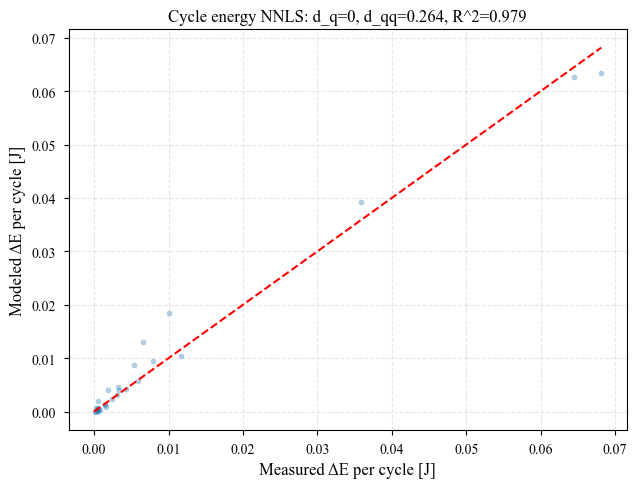

FINAL IDENTIFIED VECTOR (for Step4 init/compare):
beta = [I_id=0.17883, d_q=0.000000, d_qq=0.264020]
K_cable (report from Step2) = 0.05475 Nm/rad


In [9]:
# --- Step 3: Energy Decay Analysis (Damping Identification) ---

print("="*82)
print(" STEP 3: ENERGY BALANCE NNLS (full energy ΔE + measured w-integrals, cycle-based)")
print("="*82)

# Why this form is the 'truth' for the Step4 damping model:
#   I*th_ddot + dq*w + dqq*|w|w + K*th = 0
# Multiply by w and integrate over [t0,t1]:
#   E(t0)-E(t1) = dq*∫ w^2 dt + dqq*∫ |w|^3 dt,  E = 0.5*I*w^2 + 0.5*K*th^2
# This avoids the problematic assumption “w≈0 at peaks” and uses the same dissipation law as Step4.

from scipy.optimize import nnls

I_sys = float(I_id)
K_sys = float(K_eff_ident)
omega_sys = float(np.sqrt(K_sys / I_sys))
T_ref = 2 * np.pi / omega_sys
T_gate_lo = 0.7 * T_ref
T_gate_hi = 1.3 * T_ref

AMP_MIN_DEG = 0.7       # cycle amplitude gate (deg)
MIN_CYCLES = 12         # minimum number of valid cycles for stable NNLS

def _zero_crossing_times_local(x, dt):
    x = np.asarray(x, dtype=float)
    if x.size < 2:
        return np.array([])
    s = np.sign(x)
    s[s == 0] = 1.0
    idx = np.where(s[:-1] * s[1:] < 0)[0]
    if idx.size == 0:
        return np.array([])
    x0 = x[idx]
    x1 = x[idx + 1]
    denom = (x1 - x0)
    denom[denom == 0] = np.nan
    alpha = -x0 / denom
    t = (idx + alpha) * dt
    t = t[np.isfinite(t)]
    return t

def _idx_from_time(t, dt, n):
    i = int(np.round(t / dt))
    return int(np.clip(i, 0, n - 1))

Y_dE = []
X_int_w2 = []
X_int_w3 = []
A_used = []
T_used = []

n_cycles_total = 0
n_cycles_used = 0
n_filtered_amp = 0
n_filtered_T = 0
n_filtered_sign = 0
n_filtered_bad = 0

for seg_idx, th_seg_rad in enumerate(Theta_stack):
    th_deg = np.degrees(th_seg_rad)
    theta = np.radians(th_deg - 90.0)
    n = theta.size
    if n < 3000:
        continue

    # angular rate w (rad/s): prefer q_stack if aligned; else numerical derivative
    w = None
    try:
        if 'q_stack' in globals() and seg_idx < len(q_stack):
            w_candidate = np.asarray(q_stack[seg_idx], dtype=float)
            if w_candidate.size == n and np.all(np.isfinite(w_candidate)):
                w = w_candidate
    except Exception:
        w = None
    if w is None:
        w = np.gradient(theta, dt_uniform)

    # zero crossings to define full cycles: zc[k] -> zc[k+2]
    tzc = _zero_crossing_times_local(theta, dt_uniform)
    if tzc.size < 6:
        continue
    # drop crossings too close to edges
    tzc = tzc[(tzc > 0.2) & (tzc < (n * dt_uniform - 0.2))]
    if tzc.size < 6:
        continue

    for k in range(tzc.size - 2):
        t0 = float(tzc[k])
        t1 = float(tzc[k + 2])
        T = t1 - t0
        n_cycles_total += 1
        if T < T_gate_lo or T > T_gate_hi:
            n_filtered_T += 1
            continue
        i0 = _idx_from_time(t0, dt_uniform, n)
        i1 = _idx_from_time(t1, dt_uniform, n)
        if i1 <= i0 + 20:
            n_filtered_bad += 1
            continue

        # amplitude proxy within the cycle
        A = float(np.max(np.abs(theta[i0:i1+1])))
        if A < np.radians(AMP_MIN_DEG):
            n_filtered_amp += 1
            continue

        # energy at endpoints (full energy)
        E0 = 0.5 * I_sys * (w[i0] ** 2) + 0.5 * K_sys * (theta[i0] ** 2)
        E1 = 0.5 * I_sys * (w[i1] ** 2) + 0.5 * K_sys * (theta[i1] ** 2)
        dE = float(E0 - E1)
        if not np.isfinite(dE) or dE <= 0:
            n_filtered_sign += 1
            continue

        w_seg = w[i0:i1+1]
        int_w2 = float(np.trapezoid(w_seg**2, dx=dt_uniform))
        int_w3 = float(np.trapezoid(np.abs(w_seg)**3, dx=dt_uniform))
        if int_w2 <= 0 or int_w3 < 0 or (not np.isfinite(int_w2)) or (not np.isfinite(int_w3)):
            n_filtered_bad += 1
            continue

        Y_dE.append(dE)
        X_int_w2.append(int_w2)
        X_int_w3.append(int_w3)
        A_used.append(A)
        T_used.append(T)
        n_cycles_used += 1

Y_reg = np.asarray(Y_dE, dtype=float)
X_reg = np.vstack([X_int_w2, X_int_w3]).T if len(X_int_w2) else np.zeros((0, 2), dtype=float)

print(f"omega_sys: {omega_sys:.4f} rad/s | T_ref={T_ref:.4f}s | gate=[{T_gate_lo:.3f},{T_gate_hi:.3f}]s")
print(f"Cycles total: {n_cycles_total} | used: {n_cycles_used}")
print(f"Filtered: amp={n_filtered_amp}, T_gate={n_filtered_T}, dE<=0={n_filtered_sign}, bad={n_filtered_bad}")

if Y_reg.size < MIN_CYCLES:
    raise RuntimeError(f"Not enough valid cycles for NNLS (need >= {MIN_CYCLES}, got {Y_reg.size}).")

# NNLS fit
coeffs_nnls, rnorm = nnls(X_reg, Y_reg)
d_q_final = float(coeffs_nnls[0])
d_qq_final = float(coeffs_nnls[1])

Y_pred = d_q_final * X_reg[:, 0] + d_qq_final * X_reg[:, 1]
SS_res = float(np.sum((Y_reg - Y_pred) ** 2))
SS_tot = float(np.sum((Y_reg - np.mean(Y_reg)) ** 2))
R_squared = 1.0 - SS_res / SS_tot if SS_tot > 0 else np.nan

A_deg = np.degrees(np.asarray(A_used, dtype=float))
print("-" * 82)
print("NNLS identified damping (cycle-based full-energy balance):")
print(f"  d_q   = {d_q_final:.6f}  [N·m·s/rad]")
print(f"  d_qq  = {d_qq_final:.6f}  [N·m·s^2/rad^2]")
print(f"  Fit: R^2 = {R_squared:.4f} | rnorm = {rnorm:.4e}")
print(f"  Amp used: {np.nanmin(A_deg):.2f}–{np.nanmax(A_deg):.2f} deg (mean {np.nanmean(A_deg):.2f})")
print(f"  Period used: {np.nanmin(T_used):.3f}–{np.nanmax(T_used):.3f} s")
print("-" * 82)

plt.figure(figsize=(7.2, 5.2))
plt.scatter(Y_reg, Y_pred, alpha=0.35, s=14)
m = max(np.max(Y_reg), np.max(Y_pred))
plt.plot([0, m], [0, m], 'r--', lw=1.5)
plt.xlabel('Measured ΔE per cycle [J]')
plt.ylabel('Modeled ΔE per cycle [J]')
plt.title(f'Cycle energy NNLS: d_q={d_q_final:.3g}, d_qq={d_qq_final:.3g}, R^2={R_squared:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

print("FINAL IDENTIFIED VECTOR (for Step4 init/compare):")
print(f"beta = [I_id={I_id:.5f}, d_q={d_q_final:.6f}, d_qq={d_qq_final:.6f}]")
print(f"K_cable (report from Step2) = {K_cab_id:.5f} Nm/rad")

 STEP 4: FREE-DECAY ID (mu_theta, dq, dqq, K_cable) with nonlinear restore moment (NO per-segment Ki)
Restore: using theta_abs in trig with xb=x_b=0.025350, zb=z_b=0.000000; linear slope near 90deg is +B*x_b
Bounds: MU_BND=(0.5738037491584004, 1.0) (USE_MU_MIN_HARD=True, mu_min_conservative=0.5738)
Bounds: DQ_BND=(0.0, 5.0) | DQQ_BND=(0.0, 5.0) | KC_BND=(0.0, 0.55257695032573) | FIT_KCABLE=True
Segments: 3 | dt=0.001 s | downsample target=2500
I0=I_yy_dry - M_q_outer = 0.172410 | Iwater=0.011190 | use_qdot=True

Initial guess (from Step3/2 when available):
  mu0   = 0.5738   (source: mu_identified or I_id fallback)
  dq0   = 0.000000 (source: d_q_final)
  dqq0  = 0.264020 (source: d_qq_final)
  Kc0   = 0.054747 (source: K_cab_id)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.6781e+03                                    6.17e+05    
   Iteration     Total nfev        Cost      Cost reduction    Step norm     O

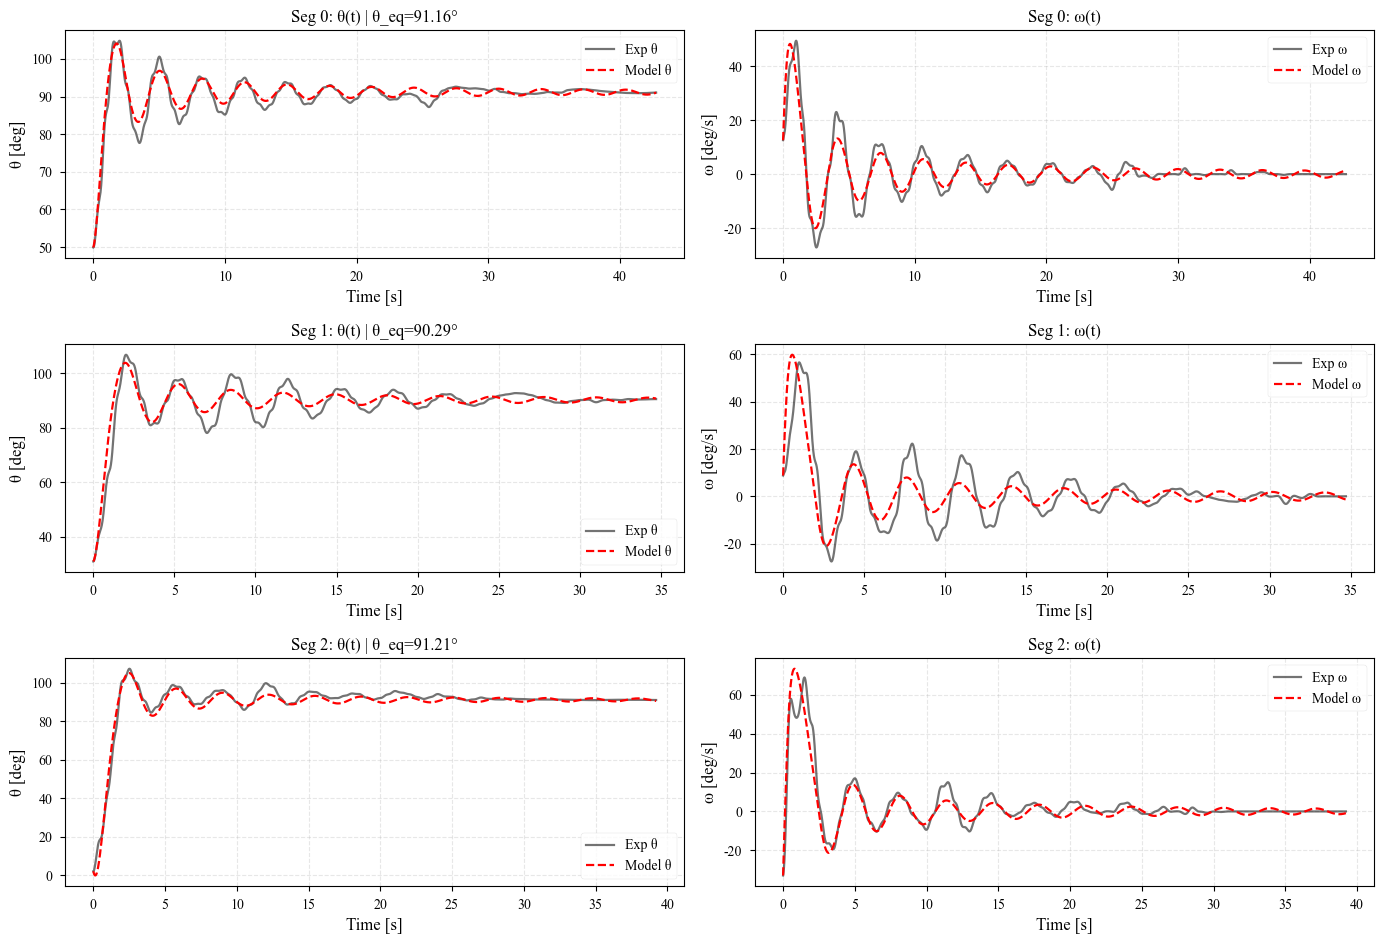

In [ ]:
# --- Step 4 (REPLACED): Pitch Free-Decay Identification (mu_theta, dq, dqq, K_cable) ---
print("="*80)
print(" STEP 4: FREE-DECAY ID (mu_theta, dq, dqq, K_cable) with nonlinear restore moment (NO per-segment Ki)")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# ---- Guardrails / data interface ----
if 'Theta_stack' not in globals() or 'q_stack' not in globals():
    raise RuntimeError("Missing Theta_stack/q_stack. Run segmentation first.")
if len(Theta_stack) != len(q_stack):
    raise RuntimeError(f"Theta_stack and q_stack length mismatch: {len(Theta_stack)} vs {len(q_stack)}")
if 'dt_uniform' not in globals():
    raise RuntimeError("Missing dt_uniform. Run Step 1 first.")

nseg = len(Theta_stack)
if nseg < 1:
    raise RuntimeError("Need >=1 segment for fitting.")

# Required constants (aligned to notebook names)
required = ['I_yy_dry', 'M_q_outer', 'I_water_inner', 'B_force', 'x_b', 'z_b']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Missing required constants: {missing}")

I_yy_dry = float(I_yy_dry)
M_q_outer = float(M_q_outer)
I_water_inner = float(I_water_inner)
B_force = float(B_force)
x_b = float(x_b)
z_b = float(z_b)

# Model constants
I0 = float(I_yy_dry - M_q_outer)      # note: M_q_outer is typically negative
Iwater = float(I_water_inner)         # water inertia about y axis (inner water)
B = float(B_force)

# IMPORTANT alignment with existing notebook convention:
# - State uses theta_dev = theta_abs - pi/2 (equilibrium near 90deg).
# - Step2/3 uses K_geo_val = B_force * x_b, meaning the *linearized* restore slope near theta_dev=0 is +B*x_b.
# For nonlinear restore, use trig on theta_abs and choose sign so that:
#   d/d(theta_dev) M_restore(theta_abs=pi/2+theta_dev) |0 = +B*x_b
# which is achieved by: M_restore = -B*(z_b*sin(theta_abs) + x_b*cos(theta_abs)).
xb_model = float(x_b)
zb_model = float(z_b)
print(f"Restore: using theta_abs in trig with xb=x_b={xb_model:.6f}, zb=z_b={zb_model:.6f}; linear slope near 90deg is +B*x_b")

# Hyperparameters (override via globals if needed)
TARGET_POINTS_PER_SEG = int(globals().get('TARGET_POINTS_PER_SEG', 2500))
LATE_WINDOW_S = float(globals().get('LATE_WINDOW_S', 2.0))
LAMBDA_OMEGA = float(globals().get('LAMBDA_OMEGA', 1.0))
FIT_sK = bool(globals().get('FIT_sK', False))
sK0 = float(globals().get('sK0', 1.0))
USE_QDOT = bool(globals().get('USE_QDOT', True))
N_BOOT = int(globals().get('N_BOOT', 0))
BOOT_BLOCK_S = float(globals().get('BOOT_BLOCK_S', 1.0))

# New: explicit linear cable stiffness term K_cable * (theta - theta_eq)
FIT_KCABLE = bool(globals().get('FIT_KCABLE', True))

# Bounds (allow override via globals; optionally enforce mu >= mu_min_conservative from Step2)
MU_BND_USER = globals().get('MU_BND', (0.0, 1.0))
MU_BND_USER = tuple(MU_BND_USER) if (isinstance(MU_BND_USER, (tuple, list)) and len(MU_BND_USER) == 2) else (0.0, 1.0)
DQ_BND = tuple(globals().get('DQ_BND', (0.0, 5.0)))
DQQ_BND = tuple(globals().get('DQQ_BND', (0.0, 5.0)))
SK_BND = tuple(globals().get('SK_BND', (0.85, 1.15)))

USE_MU_MIN_HARD = bool(globals().get('USE_MU_MIN_HARD', True))
mu_min_hard = float(globals().get('mu_min_conservative', 0.0)) if USE_MU_MIN_HARD else 0.0
MU_BND = (max(float(MU_BND_USER[0]), mu_min_hard), float(MU_BND_USER[1]))

kc_ub_guess = None
if 'Kc_mu1_band_hi' in globals():
    kc_ub_guess = 5.0 * float(Kc_mu1_band_hi)
elif 'K_cab_id' in globals():
    kc_ub_guess = 5.0 * float(K_cab_id)
elif 'K_cable_est' in globals():
    kc_ub_guess = 5.0 * max(0.0, float(K_cable_est))
else:
    kc_ub_guess = 0.5
kc_ub_guess = float(max(kc_ub_guess, 1e-6))
KC_BND = globals().get('KC_BND', (0.0, kc_ub_guess))
KC_BND = tuple(KC_BND) if (isinstance(KC_BND, (tuple, list)) and len(KC_BND) == 2) else (0.0, kc_ub_guess)

print(f"Bounds: MU_BND={MU_BND} (USE_MU_MIN_HARD={USE_MU_MIN_HARD}, mu_min_conservative={float(globals().get('mu_min_conservative', 0.0)):.4f})")
print(f"Bounds: DQ_BND={DQ_BND} | DQQ_BND={DQQ_BND} | KC_BND={KC_BND} | FIT_KCABLE={FIT_KCABLE}")

# ---- Helpers ----
def robust_mad(x, eps=1e-12):
    x = np.asarray(x, dtype=float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 1.4826 * mad + eps

def _downsample_indices(n, target_points):
    if n <= target_points:
        return np.arange(n, dtype=int)
    idx = np.linspace(0, n - 1, num=target_points, dtype=int)
    return np.unique(idx)

def prep_segment(theta_abs, omega, dt, omega_dot=None, late_window_s=2.0, detrend_omega=True, target_points=2500):
    """
    theta_abs: absolute pitch [rad], near pi/2 (90deg) equilibrium in this notebook
    omega    : q [rad/s] aligned with theta_abs
    Returns segment with theta_dev = theta_abs - pi/2 (small angle around 0).
    """
    theta_abs = np.asarray(theta_abs, dtype=float)
    omega = np.asarray(omega, dtype=float)
    if theta_abs.size != omega.size:
        raise ValueError("theta/omega length mismatch")
    if theta_abs.size < 30:
        raise ValueError("segment too short")
    t_full = np.arange(theta_abs.size, dtype=float) * float(dt)

    # convert to deviation around vertical equilibrium (90deg)
    theta_dev_full = theta_abs - 0.5 * np.pi

    # tail equilibrium/bias (on theta_dev)
    n_tail = max(10, int(late_window_s / float(dt)))
    n_tail = min(n_tail, theta_abs.size)
    theta_eq = float(np.median(theta_dev_full[-n_tail:]))
    theta_eq_abs = float(theta_eq + 0.5 * np.pi)
    omega_bias = float(np.median(omega[-n_tail:])) if detrend_omega else 0.0

    theta_dev_adj = theta_dev_full.copy()
    omega_adj = omega - omega_bias

    # downsample for speed/stability
    idx = _downsample_indices(theta_abs.size, int(target_points))
    t = t_full[idx]
    th = theta_dev_adj[idx]
    om = omega_adj[idx]
    th_abs = theta_abs[idx]

    seg = {
        't': t,
        'theta': th,
        'theta_abs': th_abs,
        'omega': om,
        'theta_eq': theta_eq,
        'theta_eq_abs': theta_eq_abs,
        'scale_theta': robust_mad(th),
        'scale_omega': robust_mad(om),
        'omega_bias': omega_bias,
        'idx': idx
    }

    if omega_dot is not None:
        omega_dot = np.asarray(omega_dot, dtype=float)
        if omega_dot.size != theta_abs.size:
            raise ValueError("omega_dot length mismatch")
        seg['omega_dot'] = omega_dot[idx]

    return seg

def M_restore(theta_abs, B, xb, zb):
    # Nonlinear restore using absolute angle theta_abs [rad].
    # Sign is chosen so linearization about theta_abs=pi/2 matches +B*x_b slope vs theta_dev.
    return -B * (zb * np.sin(theta_abs) + xb * np.cos(theta_abs))

def M_restore_tilde(theta_abs, theta_eq_abs, B, xb, zb, sK=1.0):
    return float(sK) * (M_restore(theta_abs, B, xb, zb) - M_restore(theta_eq_abs, B, xb, zb))

def Ieff_from_mu(mu, I0, Iwater, eps=1e-9):
    return max(I0 + float(mu) * Iwater, eps)

# ---- Stage 0: build segments ----
segments = []
has_qdot = ('q_dot_stack' in globals()) and isinstance(q_dot_stack, list) and (len(q_dot_stack) == nseg)
use_qdot = bool(USE_QDOT and has_qdot)
for i in range(nseg):
    omdot_i = q_dot_stack[i] if use_qdot else None
    seg = prep_segment(
        Theta_stack[i], q_stack[i], dt_uniform,
        omega_dot=omdot_i,
        late_window_s=LATE_WINDOW_S,
        detrend_omega=True,
        target_points=TARGET_POINTS_PER_SEG
    )
    segments.append(seg)

print(f"Segments: {nseg} | dt={dt_uniform} s | downsample target={TARGET_POINTS_PER_SEG}")
print(f"I0=I_yy_dry - M_q_outer = {I0:.6f} | Iwater={Iwater:.6f} | use_qdot={use_qdot}")

# ---- Initial guess (prefer Step3/Step2 outputs; avoid duplicate work) ----
# Step3 provides damping (d_q_final, d_qq_final). Step2 provides inertia proxy (mu_identified or I_id) and cable stiffness (K_cab_id).
def _get_init_value(name, default=None):
    v = globals().get(name, default)
    try:
        return float(v)
    except Exception:
        return float(default) if default is not None else None

mu0 = _get_init_value('mu_identified', None)
if mu0 is None and ('I_id' in globals()):
    mu0 = float((float(globals()['I_id']) - I0) / (Iwater + 1e-12))
if mu0 is None:
    mu0 = 0.5
mu0 = float(np.clip(mu0, MU_BND[0], MU_BND[1]))

dq0 = _get_init_value('d_q_final', None)
if dq0 is None:
    dq0 = _get_init_value('dq_final', 0.05)
dq0 = float(np.clip(max(0.0, dq0), DQ_BND[0], DQ_BND[1]))

dqq0 = _get_init_value('d_qq_final', None)
if dqq0 is None:
    dqq0 = _get_init_value('dqq_final', 0.05)
dqq0 = float(np.clip(max(0.0, dqq0), DQQ_BND[0], DQQ_BND[1]))

Kc0 = _get_init_value('K_cab_id', None)
if Kc0 is None:
    Kc0 = _get_init_value('K_cable_est', 0.0)
Kc0 = float(np.clip(max(0.0, Kc0), KC_BND[0], KC_BND[1]))

print("\nInitial (from Step3 when available):")
print(f"  mu0   = {mu0:.4f}   (source: mu_identified or I_id fallback)")
print(f"  dq0   = {dq0:.6f} (source: d_q_final)")
print(f"  dqq0  = {dqq0:.6f} (source: d_qq_final)")
print(f"  Kc0   = {Kc0:.6f} (source: K_cab_id)")

# ---- Stage 2: ODE forward simulation + robust least_squares ----
def simulate_segment(t, theta0, omega0, theta_eq, mu, dq, dqq, Kc, I0, Iwater, B, xb, zb, sK=1.0):
    Ieff = Ieff_from_mu(mu, I0, Iwater)
    def f(_, y):
        th, om = y
        phi = th - float(theta_eq)
        th_abs = th + 0.5 * np.pi
        th_eq_abs = float(theta_eq) + 0.5 * np.pi
        Mtil = M_restore_tilde(th_abs, th_eq_abs, B, xb, zb, sK=sK)
        Mtot = Mtil + float(Kc) * phi
        dom = -(dq * om + dqq * np.abs(om) * om + Mtot) / Ieff
        return [om, dom]
    sol = solve_ivp(
        f, (float(t[0]), float(t[-1])), [float(theta0), float(omega0)],
        t_eval=t, method='RK45', rtol=1e-6, atol=1e-8
    )
    if (not sol.success) or (sol.y.shape[1] != len(t)):
        return None
    return sol.y[0], sol.y[1]

def residuals_global(x, segs, I0, Iwater, B, xb, zb, fit_kcable=False, fit_sK=False, lambda_omega=1.0, prior_sK_sigma=0.05):
    idx = 0
    mu = float(x[idx]); idx += 1
    dq = float(x[idx]); idx += 1
    dqq = float(x[idx]); idx += 1
    Kc = float(x[idx]) if fit_kcable else 0.0
    idx += 1 if fit_kcable else 0
    sK = float(x[idx]) if fit_sK else 1.0

    r_list = []
    for seg in segs:
        t = seg['t']
        th_meas = seg['theta']
        om_meas = seg['omega']
        th0 = float(th_meas[0])
        om0 = float(om_meas[0])
        sim = simulate_segment(
            t, th0, om0, seg['theta_eq'], mu, dq, dqq, Kc, I0, Iwater, B, xb, zb, sK=sK
        )
        if sim is None:
            r_list.append(np.ones_like(th_meas) * 1e3)
            r_list.append(np.ones_like(om_meas) * 1e3)
            continue
        th_pred, om_pred = sim
        r_th = (th_pred - th_meas) / seg['scale_theta']
        r_om = np.sqrt(float(lambda_omega)) * (om_pred - om_meas) / seg['scale_omega']
        r_list.append(r_th)
        r_list.append(r_om)

    if fit_sK:
        r_list.append(np.array([(sK - 1.0) / float(prior_sK_sigma)], dtype=float))
    return np.concatenate(r_list)

def stage2_fit(segs, I0, Iwater, B, xb, zb, mu0, dq0, dqq0, Kc0, fit_kcable=False, fit_sK=False, sK0=1.0, lambda_omega=1.0):
    x0 = [float(mu0), float(dq0), float(dqq0)]
    lb = [float(MU_BND[0]), float(DQ_BND[0]), float(DQQ_BND[0])]
    ub = [float(MU_BND[1]), float(DQ_BND[1]), float(DQQ_BND[1])]

    if fit_kcable:
        x0.append(float(np.clip(Kc0, KC_BND[0], KC_BND[1])))
        lb.append(float(KC_BND[0]))
        ub.append(float(KC_BND[1]))

    if fit_sK:
        x0.append(float(sK0))
        lb.append(float(SK_BND[0]))
        ub.append(float(SK_BND[1]))

    x0 = np.asarray(x0, dtype=float)
    lb = np.asarray(lb, dtype=float)
    ub = np.asarray(ub, dtype=float)

    res = least_squares(
        residuals_global, x0, bounds=(lb, ub),
        loss='huber', f_scale=1.0,
        args=(segs, I0, Iwater, B, xb, zb, fit_kcable, fit_sK, lambda_omega),
        max_nfev=250, verbose=2
    )
    return res

res = stage2_fit(
    segments, I0, Iwater, B, xb_model, zb_model,
    mu0=mu0, dq0=dq0, dqq0=dqq0, Kc0=Kc0,
    fit_kcable=FIT_KCABLE,
    fit_sK=FIT_sK, sK0=sK0,
    lambda_omega=LAMBDA_OMEGA
)

# unpack
idx = 0
mu_hat = float(res.x[idx]); idx += 1
dq_final = float(res.x[idx]); idx += 1
dqq_final = float(res.x[idx]); idx += 1
Kc_final = float(res.x[idx]) if FIT_KCABLE else 0.0
idx += 1 if FIT_KCABLE else 0
sK_final = float(res.x[idx]) if FIT_sK else 1.0

Ieff_final = Ieff_from_mu(mu_hat, I0, Iwater)

print("\nStage2 (final):")
print(f"  success  = {res.success} | status={res.status} | cost={res.cost:.6e}")
print(f"  mu_theta = {mu_hat:.4f}")
print(f"  dq       = {dq_final:.6f}")
print(f"  dqq      = {dqq_final:.6f}")
print(f"  K_cable  = {Kc_final:.6f} (FIT_KCABLE={FIT_KCABLE})")
print(f"  sK       = {sK_final:.4f}")
print(f"  Ieff     = {Ieff_final:.6f}")

# Save for downstream reporting
pitch_free_decay_results = {
    'mu_theta': mu_hat,
    'dq': dq_final,
    'dqq': dqq_final,
    'K_cable': Kc_final,
    'sK': sK_final,
    'I0': I0,
    'Iwater': Iwater,
    'Ieff': Ieff_final,
    'B': B,
    'xb_model': xb_model,
    'zb_model': zb_model,
    'dt': float(dt_uniform),
    'fit_sK': bool(FIT_sK),
    'fit_kcable': bool(FIT_KCABLE),
    'MU_BND': MU_BND,
    'KC_BND': KC_BND,
    'res': res,
    'segments': segments,
}
mu_theta_identified = mu_hat  # convenience alias

# ---- Plot fit per segment (theta_abs, omega) ----
fig, axes = plt.subplots(nseg, 2, figsize=(14, 3.2 * nseg), sharex=False)
if nseg == 1:
    axes = np.array([axes])

for i in range(nseg):
    seg = segments[i]
    t = seg['t']
    th_meas = seg['theta']
    th_meas_abs = seg['theta_abs']
    om_meas = seg['omega']

    sim = simulate_segment(
        t, float(th_meas[0]), float(om_meas[0]), seg['theta_eq'],
        mu_hat, dq_final, dqq_final, Kc_final, I0, Iwater, B, xb_model, zb_model, sK=sK_final
    )
    if sim is None:
        th_pred = np.full_like(th_meas, np.nan)
        om_pred = np.full_like(om_meas, np.nan)
    else:
        th_pred, om_pred = sim

    th_pred_abs = th_pred + 0.5 * np.pi

    ax_th = axes[i, 0]
    ax_om = axes[i, 1]

    ax_th.plot(t, np.degrees(th_meas_abs), 'k-', alpha=0.55, lw=1.6, label='Exp θ')
    ax_th.plot(t, np.degrees(th_pred_abs), 'r--', lw=1.6, label='Model θ')
    ax_th.set_title(f"Seg {i}: θ(t) | θ_eq={np.degrees(seg['theta_eq'] + 0.5*np.pi):.2f}°")
    ax_th.set_xlabel('Time [s]')
    ax_th.set_ylabel('θ [deg]')
    ax_th.grid(True, alpha=0.3)
    ax_th.legend(loc='best')

    ax_om.plot(t, np.degrees(om_meas), 'k-', alpha=0.55, lw=1.6, label='Exp ω')
    ax_om.plot(t, np.degrees(om_pred), 'r--', lw=1.6, label='Model ω')
    ax_om.set_title(f"Seg {i}: ω(t)")
    ax_om.set_xlabel('Time [s]')
    ax_om.set_ylabel('ω [deg/s]')
    ax_om.grid(True, alpha=0.3)
    ax_om.legend(loc='best')

plt.tight_layout()
plt.show()

# ---- Optional: simple block bootstrap (off by default) ----
def _block_bootstrap_1d(x, block_len, rng):
    x = np.asarray(x, dtype=float)
    n = x.size
    if n <= block_len:
        return x.copy()
    out = []
    total = 0
    while total < n:
        start = int(rng.integers(0, n - block_len))
        blk = x[start:start + block_len]
        out.append(blk)
        total += blk.size
    y = np.concatenate(out)[:n]
    return y

def bootstrap_fit(segments, n_boot=50, block_s=1.0, seed=0, mu0=0.5, dq0=0.05, dqq0=0.05, Kc0=0.0):
    rng = np.random.default_rng(int(seed))
    dt = float(dt_uniform)
    block_len = max(10, int(float(block_s) / dt))
    samples = []
    for _ in range(int(n_boot)):
        segs_b = []
        for seg in segments:
            th = _block_bootstrap_1d(seg['theta'], block_len, rng)
            om = _block_bootstrap_1d(seg['omega'], block_len, rng)
            seg_b = {
                't': seg['t'],
                'theta': th,
                'omega': om,
                'theta_eq': float(np.median(th[-max(10, min(th.size, int(LATE_WINDOW_S/dt))):])),
                'scale_theta': robust_mad(th),
                'scale_omega': robust_mad(om),
            }
            segs_b.append(seg_b)

        res_b = stage2_fit(
            segs_b, I0, Iwater, B, xb_model, zb_model,
            mu0=float(np.clip(mu0, MU_BND[0], MU_BND[1])), dq0=dq0, dqq0=dqq0, Kc0=Kc0,
            fit_kcable=FIT_KCABLE,
            fit_sK=False,
            lambda_omega=LAMBDA_OMEGA
        )
        if res_b.success:
            idx2 = 0
            mu_b = float(res_b.x[idx2]); idx2 += 1
            dq_b2 = float(res_b.x[idx2]); idx2 += 1
            dqq_b2 = float(res_b.x[idx2]); idx2 += 1
            Kc_b2 = float(res_b.x[idx2]) if FIT_KCABLE else 0.0
            samples.append([mu_b, dq_b2, dqq_b2, Kc_b2])

    return np.asarray(samples, dtype=float)

if N_BOOT > 0:
    print(f"\nBootstrap running: N_BOOT={N_BOOT} | block={BOOT_BLOCK_S}s (this may take time)")
    boot = bootstrap_fit(segments, n_boot=N_BOOT, block_s=BOOT_BLOCK_S, seed=0, mu0=mu0, dq0=dq0, dqq0=dqq0, Kc0=Kc0)
    if boot.size == 0:
        print("Bootstrap produced no successful fits.")
    else:
        mu_ci = np.percentile(boot[:, 0], [2.5, 50, 97.5])
        dq_ci = np.percentile(boot[:, 1], [2.5, 50, 97.5])
        dqq_ci = np.percentile(boot[:, 2], [2.5, 50, 97.5])
        Kc_ci = np.percentile(boot[:, 3], [2.5, 50, 97.5])
        print("Bootstrap CI95 (2.5/50/97.5):")
        print(f"  mu_theta: {mu_ci[0]:.4f} / {mu_ci[1]:.4f} / {mu_ci[2]:.4f}")
        print(f"  dq      : {dq_ci[0]:.6f} / {dq_ci[1]:.6f} / {dq_ci[2]:.6f}")
        print(f"  dqq     : {dqq_ci[0]:.6f} / {dqq_ci[1]:.6f} / {dqq_ci[2]:.6f}")
        print(f"  K_cable : {Kc_ci[0]:.6f} / {Kc_ci[1]:.6f} / {Kc_ci[2]:.6f}")
        pitch_free_decay_results['bootstrap'] = boot
        pitch_free_decay_results['ci95'] = {'mu_theta': mu_ci, 'dq': dq_ci, 'dqq': dqq_ci, 'K_cable': Kc_ci}


 STEP 4 DIAGNOSTICS: CONVERGENCE + RESIDUALS
success     = True
status      = 2
message     = `ftol` termination condition is satisfied.
nfev        = 21  (function evaluations)
njev        = 16  (Jacobian evaluations)
cost        = 7.570288e+03
optimality  = 306.37411165886107

Residual stats (normalized):
  count        = 15000
  mean         = -0.0882
  std          = 1.3393
  median|r|    = 0.5258
  95%|r|       = 2.5488
  huber_sum(r) = 15140.5757  (comparable across runs; not identical to SciPy cost scaling)


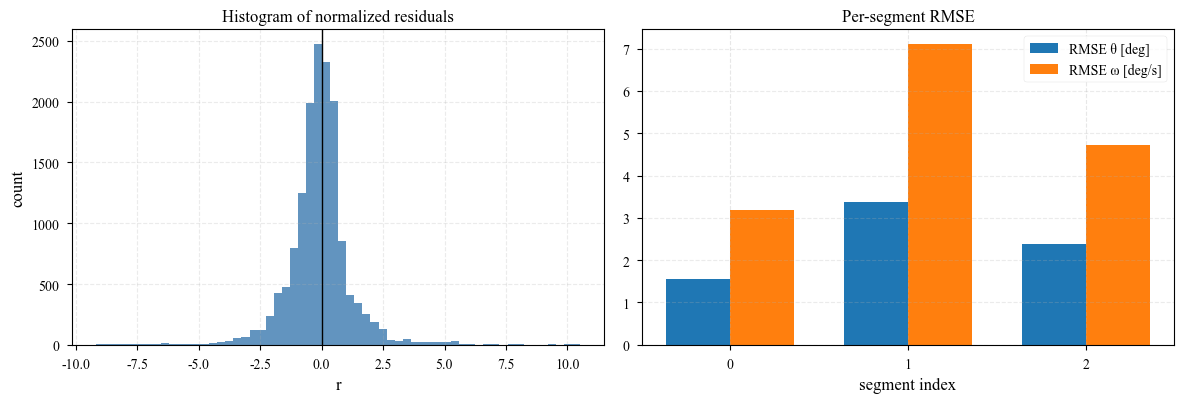

In [20]:
# --- Step 4 Diagnostics: Convergence + Residuals ---
import numpy as np
import matplotlib.pyplot as plt

# Guardrails: require that Step4 has been run
required_vars = ['res', 'segments', 'I0', 'Iwater', 'B', 'xb_model', 'zb_model', 'FIT_KCABLE', 'FIT_sK', 'LAMBDA_OMEGA']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Run Cell 15 first. Missing: {missing}")

print("\n" + "="*80)
print(" STEP 4 DIAGNOSTICS: CONVERGENCE + RESIDUALS")
print("="*80)

# ---- Convergence summary (SciPy least_squares) ----
msg = getattr(res, 'message', '(no message)')
print(f"success     = {res.success}")
print(f"status      = {res.status}")
print(f"message     = {msg}")
print(f"nfev        = {getattr(res, 'nfev', None)}  (function evaluations)")
print(f"njev        = {getattr(res, 'njev', None)}  (Jacobian evaluations)")
print(f"cost        = {res.cost:.6e}")
print(f"optimality  = {getattr(res, 'optimality', None)}")

# Note on iteration count:
# least_squares does not expose 'niter' directly; the verbose table lines (Iteration 0..k)
# correspond to trust-region steps. In your last run, the log shows Iteration 0..9 (~10 steps)
# and nfev=18.

# ---- Bound activity check ----
x = np.asarray(res.x, dtype=float)
# rebuild bounds used in Stage2
lb = [float(MU_BND[0]), float(DQ_BND[0]), float(DQQ_BND[0])]
ub = [float(MU_BND[1]), float(DQ_BND[1]), float(DQQ_BND[1])]
if bool(FIT_KCABLE):
    lb.append(float(KC_BND[0])); ub.append(float(KC_BND[1]))
if bool(FIT_sK):
    lb.append(float(SK_BND[0])); ub.append(float(SK_BND[1]))
lb = np.asarray(lb, dtype=float)
ub = np.asarray(ub, dtype=float)

rel_eps = 1e-6
hit_lb = np.isclose(x, lb, rtol=0.0, atol=rel_eps * (np.abs(lb) + 1.0))
hit_ub = np.isclose(x, ub, rtol=0.0, atol=rel_eps * (np.abs(ub) + 1.0))
if np.any(hit_lb) or np.any(hit_ub):
    print("\n[Bound activity] Some parameters are at/near bounds:")
    names = ['mu', 'dq', 'dqq']
    if bool(FIT_KCABLE):
        names.append('K_cable')
    if bool(FIT_sK):
        names.append('sK')
    for i, nm in enumerate(names):
        if hit_lb[i]:
            print(f"  {nm}: hit lower bound {lb[i]:.6g}")
        if hit_ub[i]:
            print(f"  {nm}: hit upper bound {ub[i]:.6g}")

# ---- Residual diagnostics ----
# Use the same residual function defined in Cell 15
r_final = residuals_global(res.x, segments, I0, Iwater, B, xb_model, zb_model, FIT_KCABLE, FIT_sK, LAMBDA_OMEGA)

# Huber rho (with f_scale=1.0 and delta=1.0) for interpretability
abs_r = np.abs(r_final)
rho = np.where(abs_r <= 1.0, r_final**2, 2.0*abs_r - 1.0)
print(f"\nResidual stats (normalized):")
print(f"  count        = {r_final.size}")
print(f"  mean         = {np.mean(r_final):.4f}")
print(f"  std          = {np.std(r_final):.4f}")
print(f"  median|r|    = {np.median(abs_r):.4f}")
print(f"  95%|r|       = {np.percentile(abs_r, 95):.4f}")
print(f"  huber_sum(r) = {np.sum(rho):.4f}  (comparable across runs; not identical to SciPy cost scaling)")

# ---- Per-segment RMSE in physical units (deg, deg/s) ----
rmse_theta_deg = []
rmse_omega_deg = []
for seg in segments:
    t = seg['t']
    th_meas = seg['theta']
    th_meas_abs = seg['theta_abs']
    om_meas = seg['omega']
    sim = simulate_segment(
        t, float(th_meas[0]), float(om_meas[0]), seg['theta_eq'],
        float(res.x[0]), float(res.x[1]), float(res.x[2]),
        float(res.x[3]) if bool(FIT_KCABLE) else 0.0,
        I0, Iwater, B, xb_model, zb_model,
        sK=(float(res.x[-1]) if bool(FIT_sK) else 1.0)
    )
    if sim is None:
        rmse_theta_deg.append(np.nan)
        rmse_omega_deg.append(np.nan)
        continue
    th_pred, om_pred = sim
    th_pred_abs = th_pred + 0.5*np.pi
    rmse_theta_deg.append(float(np.sqrt(np.mean((np.degrees(th_pred_abs) - np.degrees(th_meas_abs))**2))))
    rmse_omega_deg.append(float(np.sqrt(np.mean((np.degrees(om_pred) - np.degrees(om_meas))**2))))

# ---- Plots ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4.2))

# Histogram of normalized residuals
ax = axes[0]
ax.hist(r_final, bins=60, alpha=0.85, color='steelblue')
ax.axvline(0, color='k', lw=1)
ax.set_title('Histogram of normalized residuals')
ax.set_xlabel('r')
ax.set_ylabel('count')
ax.grid(True, alpha=0.25)

# RMSE bars
ax = axes[1]
idx = np.arange(len(segments))
ax.bar(idx - 0.18, rmse_theta_deg, width=0.36, label='RMSE θ [deg]')
ax.bar(idx + 0.18, rmse_omega_deg, width=0.36, label='RMSE ω [deg/s]')
ax.set_title('Per-segment RMSE')
ax.set_xlabel('segment index')
ax.set_xticks(idx)
ax.grid(True, axis='y', alpha=0.25)
ax.legend(loc='best')

plt.tight_layout()
plt.show()
